# Final Project Submission

* **Student name**: Sara Robinson
* **Student pace**: *self paced*/part time/full time
* **Scheduled project review date/time**: 10/29/2021 18:00
* **Instructor name**: Jeff Herman
* **Project Reviewer**: James Irving
* **Notebook**: 4/4

# Introduction

The purpose of this project is to do a thorough exploratory data analysis of the characters and scripts of the TV show How I Met Your Mother, as well as create a model that can predict who said which line. The data is from the website https://transcripts.foreverdreaming.org/viewforum.php?f=177 where there are nine pages containing the 208 episodes from nine seasons that the show ran.

This is the fourth notebook for my Capstone Project. This notebook contains the modeling portion of this project. The models will be attempting to predict which character said which line.

## Import Libraries

In the following cell I import the necessary libraries for this notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import collections
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import ast
import project_functions
from project_functions import *

## Load and Inspect Data

In the following cells I load the dataset we prepared in the previous notebook to be modeled and make sure everything is ready to go.

In [2]:
df = pd.read_csv('ModelDF.csv') #Read in dataset
df.head() #Checking first 5 rows

Character                                               Line  \
0  Marshall                                  will you marry me   
1       Ted  yes perfect and then youre engaged you pop the...   
2  Marshall     got it thanks for helping me plan this out ted   
3       Ted  dude are you kidding its you and lily ive been...   
4  Marshall              yeah sorry we thought you were asleep   

                                              Tokens  
0                                          ['marry']  
1  ['perfect', 'engaged', 'pop', 'champagne', 'dr...  
2               ['thanks', 'helping', 'plan', 'ted']  
3  ['dude', 'kidding', 'lily', 'big', 'moments', ...  
4                     ['sorry', 'thought', 'asleep']

In [3]:
df.info() #Making sure everything loaded correctly

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21995 entries, 0 to 21994
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Character  21995 non-null  object
 1   Line       21981 non-null  object
 2   Tokens     21995 non-null  object
dtypes: object(3)
memory usage: 515.6+ KB


There appears to be some lines missing, let's take a quick look and determine if those rows need to be removed.

In [4]:
df[df['Line'].isnull()]

Character Line   Tokens
56         Lily  NaN  ['nan']
339         Ted  NaN  ['nan']
953    Marshall  NaN       []
5879        Ted  NaN       []
7093     Barney  NaN       []
7108     Barney  NaN       []
8589       Lily  NaN       []
11571      Lily  NaN       []
11573      Lily  NaN       []
11576    Barney  NaN       []
12485     Robin  NaN       []
12527       Ted  NaN       []
16849     Robin  NaN       []
18777    Barney  NaN       []

Since there aren't that many null entries (probably due to removing stopwords), I will just go ahead and remove these entries and continue.

In [5]:
df.dropna(subset = ['Line'], inplace = True) #Dropping null entries
df.info() #Checking info again

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21981 entries, 0 to 21994
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Character  21981 non-null  object
 1   Line       21981 non-null  object
 2   Tokens     21981 non-null  object
dtypes: object(3)
memory usage: 686.9+ KB


Great! Now that everything is even, we're going to convert the clean token column from a list of strings as a string to just a list of strings, then we'll prepare everything to model.

In [6]:
df['Tokens'] = df['Tokens'].map(ast.literal_eval) #converting list of strings as string to list of strings

df.head() #Checking df

Character                                               Line  \
0  Marshall                                  will you marry me   
1       Ted  yes perfect and then youre engaged you pop the...   
2  Marshall     got it thanks for helping me plan this out ted   
3       Ted  dude are you kidding its you and lily ive been...   
4  Marshall              yeah sorry we thought you were asleep   

                                              Tokens  
0                                            [marry]  
1  [perfect, engaged, pop, champagne, drink, toas...  
2                       [thanks, helping, plan, ted]  
3  [dude, kidding, lily, big, moments, lily, nigh...  
4                           [sorry, thought, asleep]

# Preparing to Model

Before we can model the data, we need to perform a train test split and split the data into training and test sets. I am going to quickly put all of my functions for modeling above all of this to keep them together.

In [7]:
from matplotlib import rcParams
import matplotlib.font_manager
import matplotlib.font_manager as font_manager

rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

font_dir = ['/Users/robotrobz/Downloads/Dax Regular']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
    
rcParams['font.family'] = 'Dax'

In [8]:
X = df['Tokens'] #Setting X
y = df['Character'] #Setting y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, 
                                                   random_state = 56, stratify = df['Character']) #Splitting data

display(X_train.shape) #Checking shape of X_train
display(y_train.shape) #Checking shape of y_train
display(X_test.shape) #Checking shape of X_test
display(y_test.shape) #Checking shape of y_test

(14727,)

(14727,)

(7254,)

(7254,)

Great! We're all set up and ready to start modeling.

# Baseline Modeling

Things might get a little messy here because I will be usig both the Count Vectorizer and TF-IDF Vectorizer so I can compare the two on each model I run so I can truly determine which performs best. Here are the baseline models I will be running:

* Logistic Regression
* Multinomial Naive Bayes
* K Nearest Neighbors
* Random Forest
* Decision Tree
* AdaBoost

There will be 12 baseline models to look at since there will be two vectorizers for each model. For now, none of the parameters within any model will be changed, that will be saved for tuning later on. As I go through I'll be creating a new datarame that will contain the accuracy scores, precision scores, recall scores, F1 scores, Cohen's Kappa scores, Matthew's Correlation Coefficients, precision recall curve auc scores, and receiver operating characteristic auc scores. This way I can truly determine which models performed best by comparing, if any, and which to tune. Models will be distinguished using their names and vectorizers, when it comes time to tune I will also use numbers. Let's begin!

In [9]:
basescores_df = pd.DataFrame(columns = ['Model Name', 'Accuracy Score', 'Precision Score', 'Recall Score', 
                                        'F1 Score', "Cohen's Kappa Score", "Matthew's Correlation Coefficient", 
                                       'Barn PRC', 'Lily PRC', 'Mar PRC', 'Rob PRC', 'Ted PRC', 'Barn ROC', 
                                       'Lily ROC', 'Mar ROC', 'Rob ROC', 'Ted ROC'], 
                         index = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
basescores_df.head() #Checking to make sure df was created

Model Name Accuracy Score Precision Score Recall Score F1 Score  \
1        NaN            NaN             NaN          NaN      NaN   
2        NaN            NaN             NaN          NaN      NaN   
3        NaN            NaN             NaN          NaN      NaN   
4        NaN            NaN             NaN          NaN      NaN   
5        NaN            NaN             NaN          NaN      NaN   

  Cohen's Kappa Score Matthew's Correlation Coefficient Barn PRC Lily PRC  \
1                 NaN                               NaN      NaN      NaN   
2                 NaN                               NaN      NaN      NaN   
3                 NaN                               NaN      NaN      NaN   
4                 NaN                               NaN      NaN      NaN   
5                 NaN                               NaN      NaN      NaN   

  Mar PRC Rob PRC Ted PRC Barn ROC Lily ROC Mar ROC Rob ROC Ted ROC  
1     NaN     NaN     NaN      NaN      NaN     NaN     NaN     NaN  
2     NaN     NaN     NaN      NaN      NaN     NaN     NaN     NaN  
3     NaN     NaN     NaN      NaN      NaN     NaN     NaN     NaN  
4     NaN     NaN     NaN      NaN      NaN     NaN     NaN     NaN  
5     NaN     NaN     NaN      NaN      NaN     NaN     NaN     NaN

## Logistic Regression

We'll start by building a logistic regression model using the count vectorizer. We'll go through and build and evaluate the model, add the pertinent information to our new scores dataframe, then we'll start again and build another one using the tf-idf vectorizer.

### Logistic Regression using Count Vectorizer

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.75      0.66      0.71      3103
        Lily       0.78      0.56      0.65      2347
    Marshall       0.75      0.59      0.66      2795
       Robin       0.74      0.53      0.61      2496
         Ted       0.54      0.86      0.66      3986

    accuracy                           0.66     14727
   macro avg       0.71      0.64      0.66     14727
weighted avg       0.70      0.66      0.66     14727



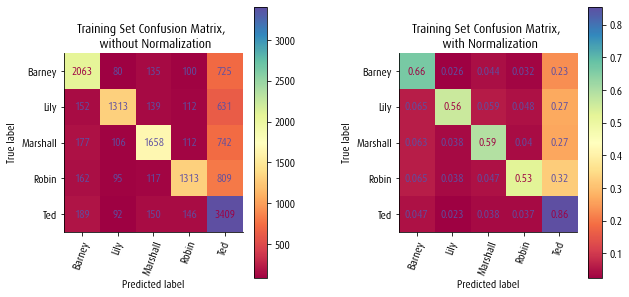

Cohen's Kappa Score for Training Set:
0.566
Matthew's Correlation Coefficient for Training Set:
0.578
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.34      0.28      0.31      1529
        Lily       0.32      0.20      0.25      1156
    Marshall       0.30      0.23      0.26      1377
       Robin       0.26      0.18      0.21      1229
         Ted       0.33      0.56      0.42      1963

    accuracy                           0.32      7254
   macro avg       0.31      0.29      0.29      7254
weighted avg       0.31      0.32      0.30      7254



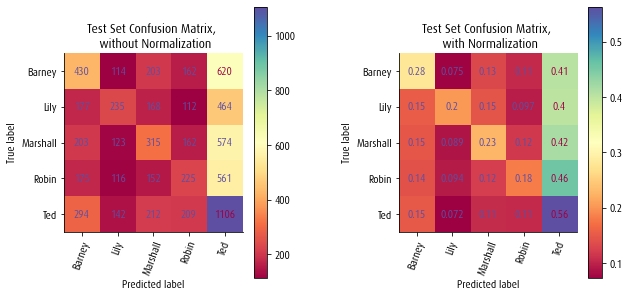

Cohen's Kappa Score for Test Set:
0.121
Matthew's Correlation Coefficient for Test Set:
0.124


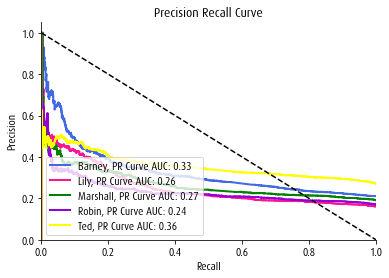

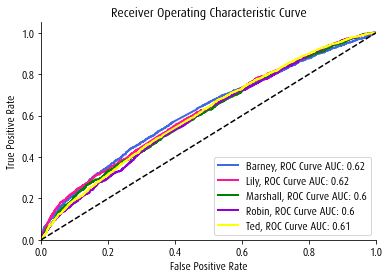

In [10]:
le = LabelEncoder() #Instantiating Label Encoder
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

LRpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression()),
]) #Creating Logistic Regression pipeline with count vectorizer

LRpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(LRpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR CV Model

confmat_and_classrep(LRpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test LR CV model

lb = LabelBinarizer() #Instantiating Label Binarizer
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = LRpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each character

basescores_df.loc['1'] = pd.Series({'Model Name': 'LogRegCV', 'Accuracy Score': 0.32, 'Precision Score': 0.31, 
                                    'Recall Score': 0.29, 'F1 Score': 0.29, "Cohen's Kappa Score": 0.121, 
                                    "Matthew's Correlation Coefficient": 0.124, 'Barn PRC': 0.33, 'Lily PRC': 0.26, 
                                   'Mar PRC': 0.27, 'Rob PRC': 0.24, 'Ted PRC': 0.36, 'Barn ROC': 0.62, 
                                   'Lily ROC': 0.62, 'Mar ROC': 0.60, 'Rob ROC': 0.60, 'Ted ROC': 0.61}) #Inputting

The accuracy for the test set is 32%, while it is 66% for the training set; this difference tells us that the model is overfit on the training data. An accuracy of 66% is better than random guessing. It makes sense that recall for Ted is the highest, as Ted has the most lines.

First one is done! And our graphs are looking pretty good, let's hustle.

### Logistic Regression using TF-IDF Vectorizer

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.65      0.63      0.64      3103
        Lily       0.72      0.44      0.55      2347
    Marshall       0.67      0.52      0.58      2795
       Robin       0.68      0.43      0.52      2496
         Ted       0.50      0.83      0.62      3986

    accuracy                           0.60     14727
   macro avg       0.64      0.57      0.58     14727
weighted avg       0.63      0.60      0.59     14727



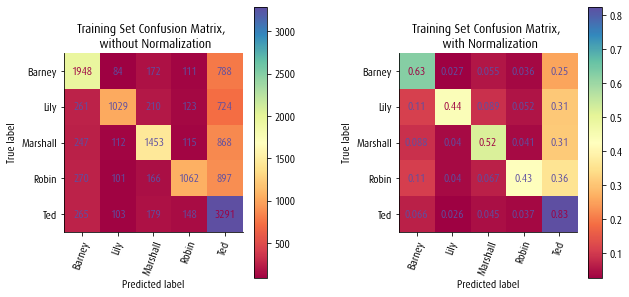

Cohen's Kappa Score for Training Set:
0.479
Matthew's Correlation Coefficient for Training Set:
0.493
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.34      0.30      0.32      1529
        Lily       0.33      0.17      0.22      1156
    Marshall       0.30      0.22      0.25      1377
       Robin       0.26      0.15      0.19      1229
         Ted       0.32      0.60      0.42      1963

    accuracy                           0.32      7254
   macro avg       0.31      0.29      0.28      7254
weighted avg       0.31      0.32      0.30      7254



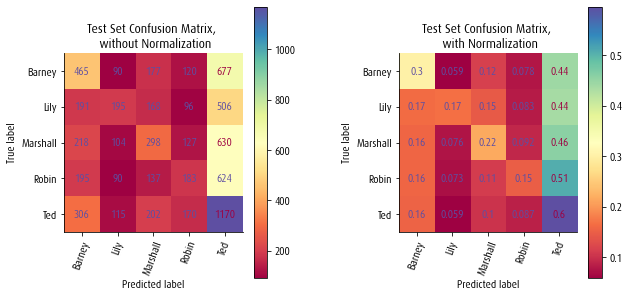

Cohen's Kappa Score for Test Set:
0.116
Matthew's Correlation Coefficient for Test Set:
0.121


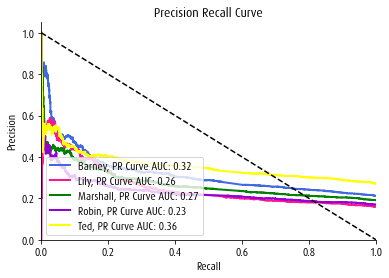

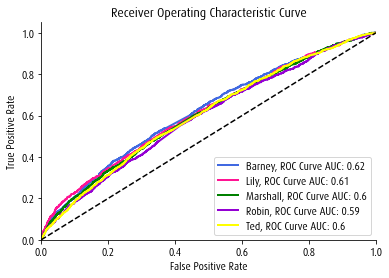

In [11]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

LRpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression()), 
]) #Creating Logistic Regression pipeline with tfidf vectorizer

LRpipelineTF.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(LRpipelineTF, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR TF Model

confmat_and_classrep(LRpipelineTF, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test LR TF Model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = LRpipelineTF.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each character

basescores_df.loc['2'] = pd.Series({'Model Name': 'LogRegTF', 'Accuracy Score': 0.32, 'Precision Score': 0.31, 
                                    'Recall Score': 0.29, 'F1 Score': 0.28, "Cohen's Kappa Score": 0.116, 
                                    "Matthew's Correlation Coefficient": 0.121, 'Barn PRC': 0.32, 'Lily PRC': 0.26, 
                                   'Mar PRC': 0.27, 'Rob PRC': 0.23, 'Ted PRC': 0.36, 'Barn ROC': 0.62, 
                                   'Lily ROC': 0.61, 'Mar ROC': 0.60, 'Rob ROC': 0.59, 'Ted ROC': 0.60}) #Inputting

There's been a slight change in curve scores, but the classification report returned the same scores. Let's move to the next model.

## Multinomial Naive Bayes

Here we'll be doing the same thing as above. We will build out two models, one with each vectorizer, and add the scores to our baseline scores dataframe.

### Multinomial Naive Bayes using Count Vectorizer

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.64      0.57      0.60      3103
        Lily       0.79      0.37      0.50      2347
    Marshall       0.70      0.47      0.56      2795
       Robin       0.75      0.36      0.48      2496
         Ted       0.44      0.87      0.59      3986

    accuracy                           0.56     14727
   macro avg       0.66      0.53      0.55     14727
weighted avg       0.64      0.56      0.55     14727



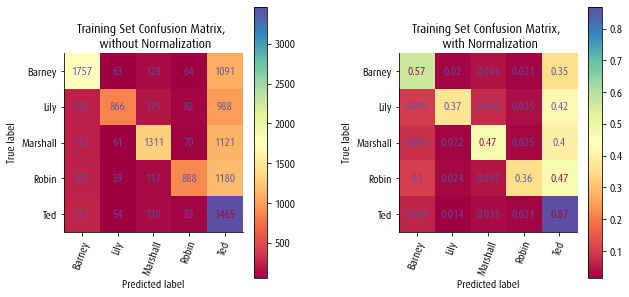

Cohen's Kappa Score for Training Set:
0.43
Matthew's Correlation Coefficient for Training Set:
0.458
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.34      0.29      0.31      1529
        Lily       0.37      0.12      0.19      1156
    Marshall       0.31      0.20      0.24      1377
       Robin       0.30      0.12      0.17      1229
         Ted       0.31      0.68      0.43      1963

    accuracy                           0.32      7254
   macro avg       0.33      0.28      0.27      7254
weighted avg       0.33      0.32      0.29      7254



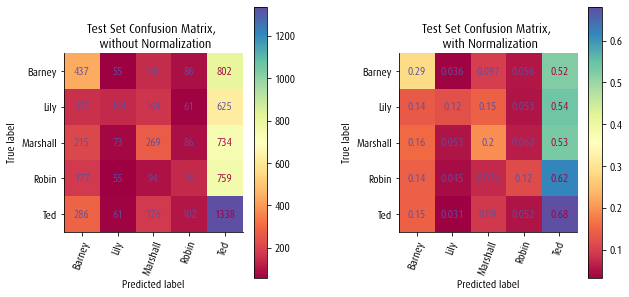

Cohen's Kappa Score for Test Set:
0.11
Matthew's Correlation Coefficient for Test Set:
0.121


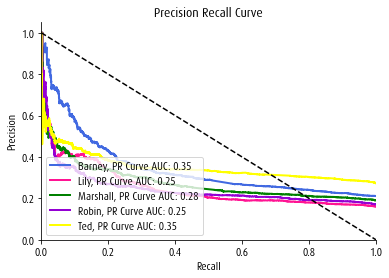

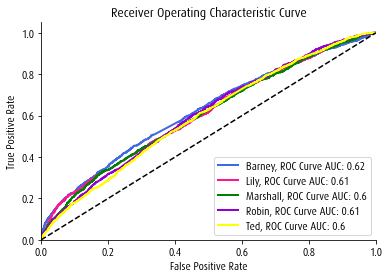

In [12]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

MNBpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', MultinomialNB()), 
]) #Creating multinomial naive bayes pipeline with count vectorizer

MNBpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(MNBpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #evaluating training MNB CV model

confmat_and_classrep(MNBpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #evaluating test MNB CV Model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = MNBpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #building roc curves for each character

basescores_df.loc['3'] = pd.Series({'Model Name': 'MNBCV', 'Accuracy Score': 0.32, 'Precision Score': 0.33, 
                                    'Recall Score': 0.28, 'F1 Score': 0.27, "Cohen's Kappa Score": 0.110, 
                                    "Matthew's Correlation Coefficient": 0.121, 'Barn PRC': 0.35, 'Lily PRC': 0.25, 
                                   'Mar PRC': 0.28, 'Rob PRC': 0.25, 'Ted PRC': 0.35, 'Barn ROC': 0.62, 
                                   'Lily ROC': 0.61, 'Mar ROC': 0.60, 'Rob ROC': 0.61, 'Ted ROC': 0.60}) #Inputting

### Multinomial Bayes using TF-IDF Vectorizer

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.70      0.51      0.59      3103
        Lily       0.86      0.24      0.37      2347
    Marshall       0.77      0.35      0.48      2795
       Robin       0.87      0.23      0.36      2496
         Ted       0.38      0.95      0.55      3986

    accuracy                           0.51     14727
   macro avg       0.72      0.46      0.47     14727
weighted avg       0.68      0.51      0.49     14727



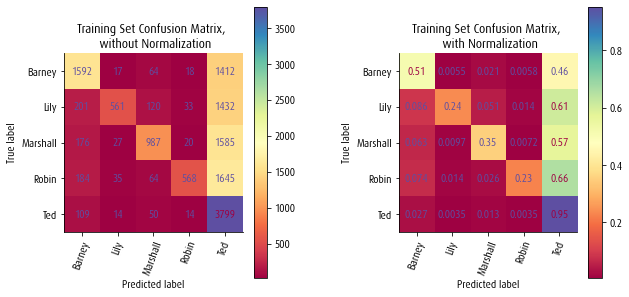

Cohen's Kappa Score for Training Set:
0.351
Matthew's Correlation Coefficient for Training Set:
0.414
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.35      0.21      0.26      1529
        Lily       0.43      0.07      0.12      1156
    Marshall       0.34      0.12      0.18      1377
       Robin       0.36      0.06      0.10      1229
         Ted       0.30      0.82      0.44      1963

    accuracy                           0.31      7254
   macro avg       0.35      0.26      0.22      7254
weighted avg       0.35      0.31      0.24      7254



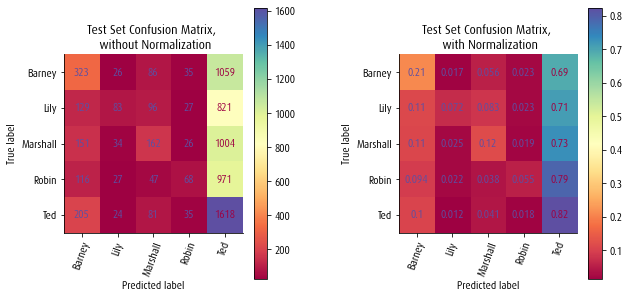

Cohen's Kappa Score for Test Set:
0.078
Matthew's Correlation Coefficient for Test Set:
0.103


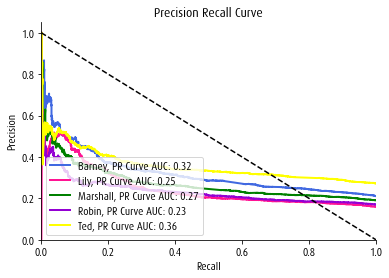

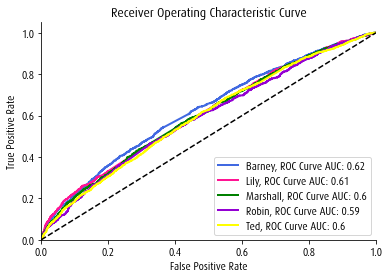

In [13]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

MNBpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', MultinomialNB()), 
]) #Creating multinomial naive bayes pipeline with tfidf vectorizer

MNBpipelineTF.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(MNBpipelineTF, X_train, y_train_enc, le.classes_, 'Training') #evaluating training MNB TF model

confmat_and_classrep(MNBpipelineTF, X_test, y_test_enc, le.classes_, 'Test') #evaluating test MNB TF model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = MNBpipelineTF.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #building roc curves for each character

basescores_df.loc['4'] = pd.Series({'Model Name': 'MNBTF', 'Accuracy Score': 0.31, 'Precision Score': 0.35, 
                                    'Recall Score': 0.26, 'F1 Score': 0.22, "Cohen's Kappa Score": 0.078, 
                                    "Matthew's Correlation Coefficient": 0.103, 'Barn PRC': 0.32, 'Lily PRC': 0.25, 
                                   'Mar PRC': 0.27, 'Rob PRC': 0.23, 'Ted PRC': 0.36, 'Barn ROC': 0.62, 
                                   'Lily ROC': 0.61, 'Mar ROC': 0.60, 'Rob ROC': 0.59, 'Ted ROC': 0.60}) #Inputting

Everything is looking good so far. I'm going to zoom through the rest of these now.

## K Nearest Neighbors

### K Nearest Neighbors using Count Vectorizer

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.45      0.56      0.50      3103
        Lily       0.45      0.39      0.42      2347
    Marshall       0.41      0.46      0.44      2795
       Robin       0.43      0.42      0.42      2496
         Ted       0.53      0.44      0.48      3986

    accuracy                           0.46     14727
   macro avg       0.46      0.45      0.45     14727
weighted avg       0.46      0.46      0.46     14727



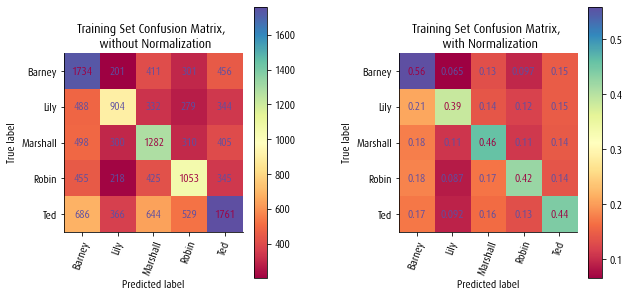

Cohen's Kappa Score for Training Set:
0.316
Matthew's Correlation Coefficient for Training Set:
0.318
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.23      0.26      0.24      1529
        Lily       0.21      0.18      0.19      1156
    Marshall       0.21      0.24      0.23      1377
       Robin       0.19      0.21      0.20      1229
         Ted       0.31      0.26      0.28      1963

    accuracy                           0.23      7254
   macro avg       0.23      0.23      0.23      7254
weighted avg       0.24      0.23      0.23      7254



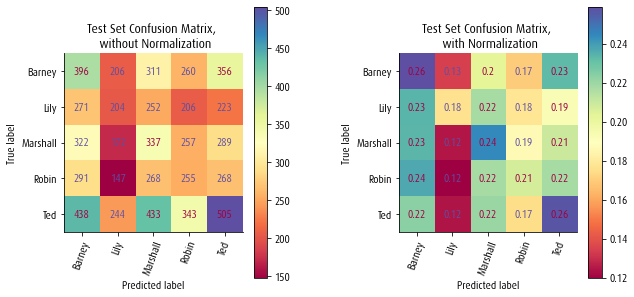

Cohen's Kappa Score for Test Set:
0.036
Matthew's Correlation Coefficient for Test Set:
0.036


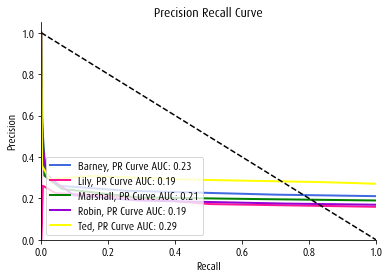

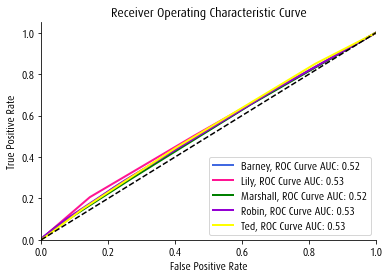

In [14]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

KNNpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', KNeighborsClassifier()), 
]) #Creating k nearest neighbors pipeline with count vectorizer

KNNpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(KNNpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #evaluating training KNN CV model

confmat_and_classrep(KNNpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #evaluating test KNN CV model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = KNNpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #building roc curves for each character

basescores_df.loc['5'] = pd.Series({'Model Name': 'KNNCV', 'Accuracy Score': 0.23, 'Precision Score': 0.23, 
                                    'Recall Score': 0.23, 'F1 Score': 0.23, "Cohen's Kappa Score": 0.036, 
                                    "Matthew's Correlation Coefficient": 0.036, 'Barn PRC': 0.23, 'Lily PRC': 0.19, 
                                   'Mar PRC': 0.21, 'Rob PRC': 0.19, 'Ted PRC': 0.29, 'Barn ROC': 0.52, 
                                   'Lily ROC': 0.53, 'Mar ROC': 0.52, 'Rob ROC': 0.53, 'Ted ROC': 0.53}) #Inputting

### K Nearest Neighbors using TF-IDF Vectorizer

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.48      0.53      0.50      3103
        Lily       0.47      0.43      0.45      2347
    Marshall       0.46      0.45      0.46      2795
       Robin       0.44      0.38      0.41      2496
         Ted       0.47      0.51      0.49      3986

    accuracy                           0.47     14727
   macro avg       0.47      0.46      0.46     14727
weighted avg       0.47      0.47      0.47     14727



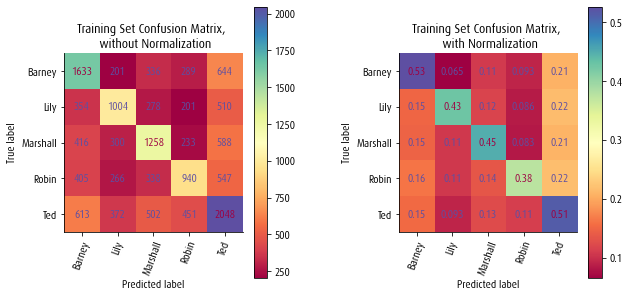

Cohen's Kappa Score for Training Set:
0.325
Matthew's Correlation Coefficient for Training Set:
0.325
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.25      0.26      0.25      1529
        Lily       0.18      0.16      0.17      1156
    Marshall       0.22      0.20      0.21      1377
       Robin       0.16      0.14      0.15      1229
         Ted       0.30      0.35      0.32      1963

    accuracy                           0.24      7254
   macro avg       0.22      0.22      0.22      7254
weighted avg       0.23      0.24      0.23      7254



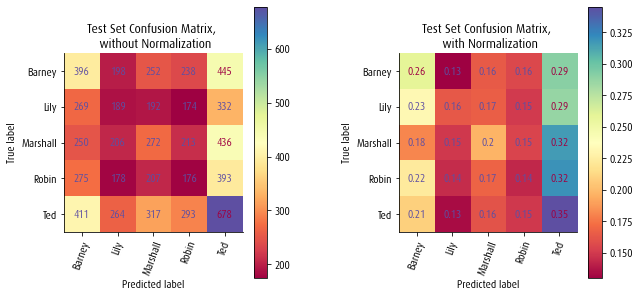

Cohen's Kappa Score for Test Set:
0.03
Matthew's Correlation Coefficient for Test Set:
0.03


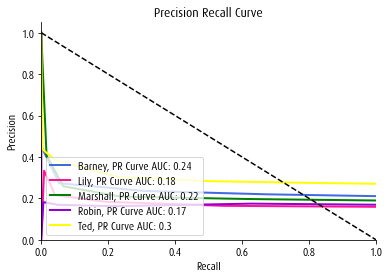

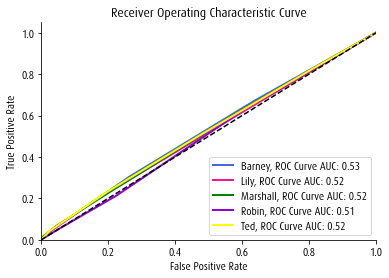

In [15]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

KNNpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', KNeighborsClassifier()), 
]) #Creating k nearest neighbors pipeline with tfidf vectorizer

KNNpipelineTF.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(KNNpipelineTF, X_train, y_train_enc, le.classes_, 'Training') #evaluating training KNN TF model

confmat_and_classrep(KNNpipelineTF, X_test, y_test_enc, le.classes_, 'Test') #evaluating test KNN TF model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = KNNpipelineTF.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #building roc curves for each character

basescores_df.loc['6'] = pd.Series({'Model Name': 'KNNCV', 'Accuracy Score': 0.24, 'Precision Score': 0.22, 
                                    'Recall Score': 0.22, 'F1 Score': 0.22, "Cohen's Kappa Score": 0.030, 
                                    "Matthew's Correlation Coefficient": 0.030, 'Barn PRC': 0.24, 'Lily PRC': 0.18, 
                                   'Mar PRC': 0.22, 'Rob PRC': 0.17, 'Ted PRC': 0.30, 'Barn ROC': 0.53, 
                                   'Lily ROC': 0.52, 'Mar ROC': 0.52, 'Rob ROC': 0.51, 'Ted ROC': 0.52}) #Inputting

## Random Forest

### Random Forest using Count Vectorizer

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.94      0.89      0.91      3103
        Lily       0.93      0.86      0.90      2347
    Marshall       0.96      0.85      0.90      2795
       Robin       0.92      0.85      0.88      2496
         Ted       0.78      0.95      0.86      3986

    accuracy                           0.89     14727
   macro avg       0.91      0.88      0.89     14727
weighted avg       0.90      0.89      0.89     14727



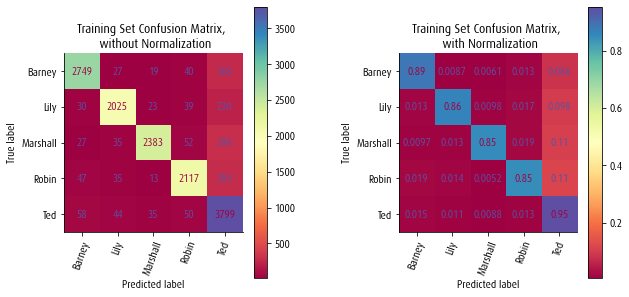

Cohen's Kappa Score for Training Set:
0.857
Matthew's Correlation Coefficient for Training Set:
0.86
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.31      0.26      0.29      1529
        Lily       0.26      0.24      0.25      1156
    Marshall       0.27      0.21      0.24      1377
       Robin       0.25      0.19      0.22      1229
         Ted       0.32      0.49      0.39      1963

    accuracy                           0.30      7254
   macro avg       0.29      0.28      0.28      7254
weighted avg       0.29      0.30      0.29      7254



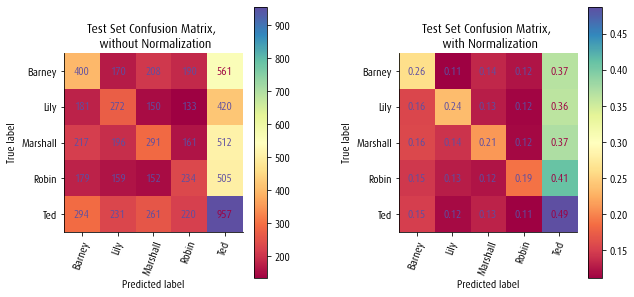

Cohen's Kappa Score for Test Set:
0.099
Matthew's Correlation Coefficient for Test Set:
0.101


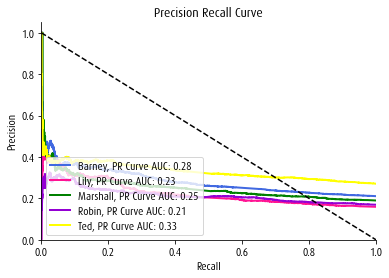

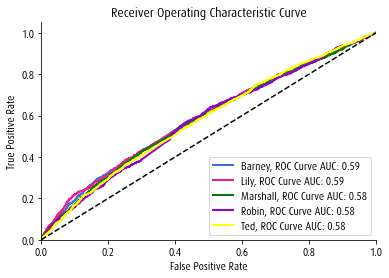

In [16]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

RFpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier()), 
]) #Creating random forest pipeline with count vectorizer

RFpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(RFpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #evaluating training RF CV model

confmat_and_classrep(RFpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #evaluating test RF CV Model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = RFpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #building roc curves for each character

basescores_df.loc['7'] = pd.Series({'Model Name': 'RFCV', 'Accuracy Score': 0.30, 'Precision Score': 0.29, 
                                    'Recall Score': 0.28, 'F1 Score': 0.28, "Cohen's Kappa Score": 0.098, 
                                    "Matthew's Correlation Coefficient": 0.099, 'Barn PRC': 0.28, 'Lily PRC': 0.23, 
                                   'Mar PRC': 0.25, 'Rob PRC': 0.22, 'Ted PRC': 0.33, 'Barn ROC': 0.59, 
                                   'Lily ROC': 0.59, 'Mar ROC': 0.58, 'Rob ROC': 0.58, 'Ted ROC': 0.58}) #Inputting

### Random Forest using TF-IDF Vectorizer

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.94      0.88      0.91      3103
        Lily       0.94      0.86      0.90      2347
    Marshall       0.95      0.86      0.90      2795
       Robin       0.92      0.84      0.88      2496
         Ted       0.78      0.95      0.86      3986

    accuracy                           0.89     14727
   macro avg       0.91      0.88      0.89     14727
weighted avg       0.90      0.89      0.89     14727



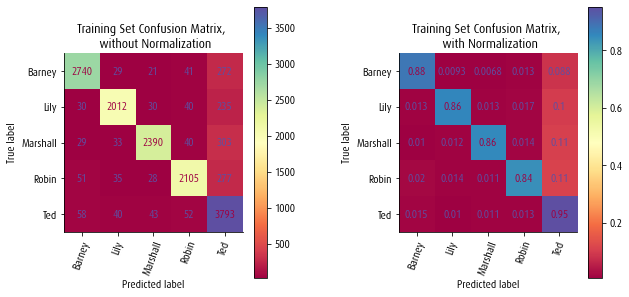

Cohen's Kappa Score for Training Set:
0.854
Matthew's Correlation Coefficient for Training Set:
0.857
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.32      0.29      0.30      1529
        Lily       0.29      0.18      0.23      1156
    Marshall       0.30      0.21      0.25      1377
       Robin       0.27      0.16      0.20      1229
         Ted       0.32      0.55      0.40      1963

    accuracy                           0.31      7254
   macro avg       0.30      0.28      0.28      7254
weighted avg       0.30      0.31      0.29      7254



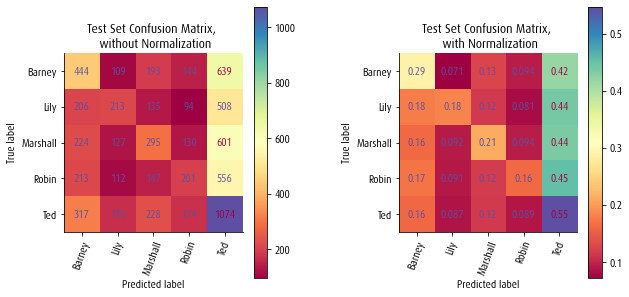

Cohen's Kappa Score for Test Set:
0.104
Matthew's Correlation Coefficient for Test Set:
0.108


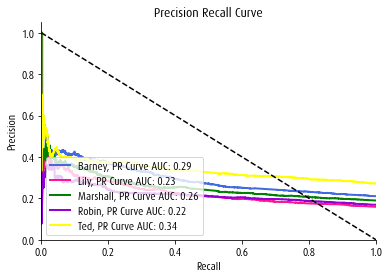

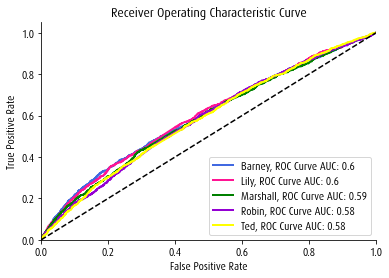

In [17]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

RFpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier()), 
]) #Creating random forest pipeline with tfidf vectorizer

RFpipelineTF.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(RFpipelineTF, X_train, y_train_enc, le.classes_, 'Training') #evaluating training RF TF model

confmat_and_classrep(RFpipelineTF, X_test, y_test_enc, le.classes_, 'Test') #evaluating test RF TF model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = RFpipelineTF.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #building roc curves for each character

basescores_df.loc['8'] = pd.Series({'Model Name': 'RFTF', 'Accuracy Score': 0.31, 'Precision Score': 0.30, 
                                    'Recall Score': 0.28, 'F1 Score': 0.28, "Cohen's Kappa Score": 0.103, 
                                    "Matthew's Correlation Coefficient": 0.106, 'Barn PRC': 0.30, 'Lily PRC': 0.23, 
                                   'Mar PRC': 0.26, 'Rob PRC': 0.22, 'Ted PRC': 0.34, 'Barn ROC': 0.59, 
                                   'Lily ROC': 0.60, 'Mar ROC': 0.59, 'Rob ROC': 0.59, 'Ted ROC': 0.58}) #Inputting

## Decision Tree

### Decision Tree using Count Vectorizer

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.91      0.91      0.91      3103
        Lily       0.92      0.88      0.90      2347
    Marshall       0.96      0.86      0.90      2795
       Robin       0.94      0.84      0.89      2496
         Ted       0.79      0.93      0.86      3986

    accuracy                           0.89     14727
   macro avg       0.90      0.88      0.89     14727
weighted avg       0.89      0.89      0.89     14727



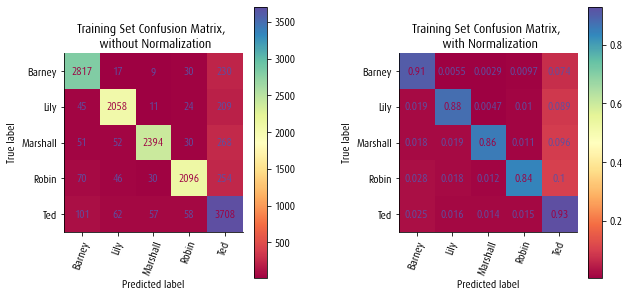

Cohen's Kappa Score for Training Set:
0.857
Matthew's Correlation Coefficient for Training Set:
0.859
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.29      0.28      0.28      1529
        Lily       0.25      0.25      0.25      1156
    Marshall       0.26      0.20      0.23      1377
       Robin       0.23      0.19      0.21      1229
         Ted       0.32      0.42      0.36      1963

    accuracy                           0.28      7254
   macro avg       0.27      0.27      0.27      7254
weighted avg       0.28      0.28      0.28      7254



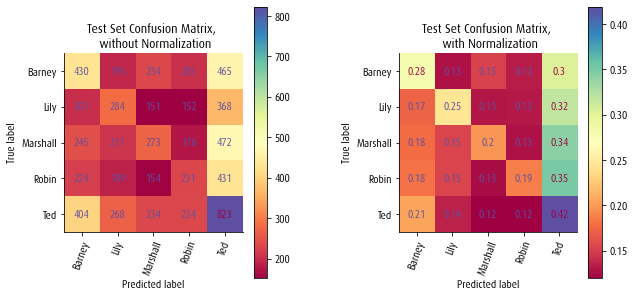

Cohen's Kappa Score for Test Set:
0.084
Matthew's Correlation Coefficient for Test Set:
0.085


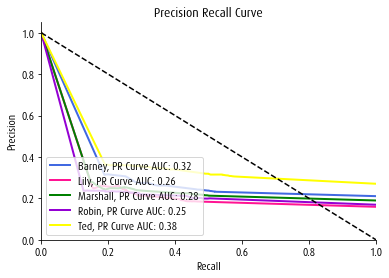

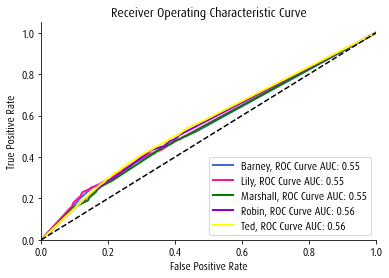

In [18]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

DTpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', DecisionTreeClassifier()), 
]) #Creating decision tree pipeline with count vectorizer

DTpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(DTpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #evaluating training DT CV model

confmat_and_classrep(DTpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #evaluating test DT CV Model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = DTpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #building roc curves for each character

basescores_df.loc['9'] = pd.Series({'Model Name': 'DTCV', 'Accuracy Score': 0.28, 'Precision Score': 0.27, 
                                    'Recall Score': 0.26, 'F1 Score': 0.26, "Cohen's Kappa Score": 0.079, 
                                    "Matthew's Correlation Coefficient": 0.080, 'Barn PRC': 0.32, 'Lily PRC': 0.25, 
                                   'Mar PRC': 0.28, 'Rob PRC': 0.25, 'Ted PRC': 0.38, 'Barn ROC': 0.56, 
                                   'Lily ROC': 0.55, 'Mar ROC': 0.54, 'Rob ROC': 0.56, 'Ted ROC': 0.56}) #Inputting

### Decision Tree using TF-IDF Vectorizer

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.92      0.90      0.91      3103
        Lily       0.92      0.88      0.90      2347
    Marshall       0.96      0.85      0.90      2795
       Robin       0.93      0.84      0.88      2496
         Ted       0.79      0.93      0.85      3986

    accuracy                           0.89     14727
   macro avg       0.90      0.88      0.89     14727
weighted avg       0.89      0.89      0.89     14727



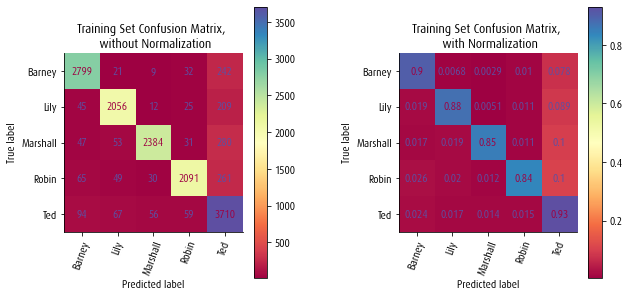

Cohen's Kappa Score for Training Set:
0.855
Matthew's Correlation Coefficient for Training Set:
0.856
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.31      0.28      0.29      1529
        Lily       0.23      0.21      0.22      1156
    Marshall       0.25      0.19      0.22      1377
       Robin       0.22      0.16      0.19      1229
         Ted       0.31      0.45      0.37      1963

    accuracy                           0.28      7254
   macro avg       0.26      0.26      0.26      7254
weighted avg       0.27      0.28      0.27      7254



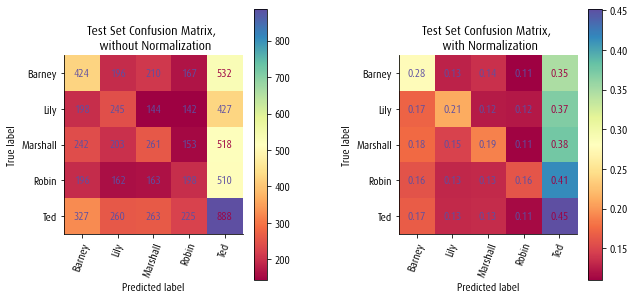

Cohen's Kappa Score for Test Set:
0.076
Matthew's Correlation Coefficient for Test Set:
0.077


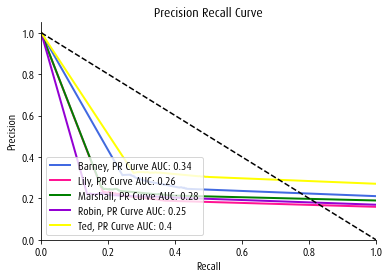

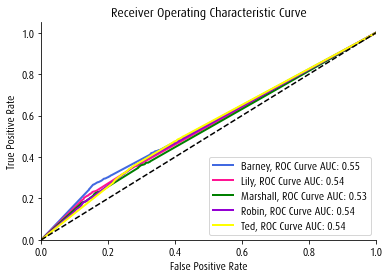

In [19]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

DTpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', DecisionTreeClassifier()), 
]) #Creating decision tree pipeline with tfidf vectorizer

DTpipelineTF.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(DTpipelineTF, X_train, y_train_enc, le.classes_, 'Training') #evaluating training DT TF model

confmat_and_classrep(DTpipelineTF, X_test, y_test_enc, le.classes_, 'Test') #evaluating test DT TF model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = DTpipelineTF.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #building roc curves for each character

basescores_df.loc['10'] = pd.Series({'Model Name': 'DTTF', 'Accuracy Score': 0.27, 'Precision Score': 0.26, 
                                    'Recall Score': 0.26, 'F1 Score': 0.25, "Cohen's Kappa Score": 0.071, 
                                    "Matthew's Correlation Coefficient": 0.072, 'Barn PRC': 0.34, 'Lily PRC': 0.25, 
                                   'Mar PRC': 0.29, 'Rob PRC': 0.25, 'Ted PRC': 0.39, 'Barn ROC': 0.55, 
                                   'Lily ROC': 0.54, 'Mar ROC': 0.54, 'Rob ROC': 0.55, 'Ted ROC': 0.54}) #Inputting

## AdaBoost

### AdaBoost using Count Vectorizer

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.42      0.12      0.18      3103
        Lily       0.54      0.05      0.10      2347
    Marshall       0.41      0.13      0.19      2795
       Robin       0.45      0.04      0.08      2496
         Ted       0.29      0.91      0.44      3986

    accuracy                           0.31     14727
   macro avg       0.42      0.25      0.20     14727
weighted avg       0.41      0.31      0.22     14727



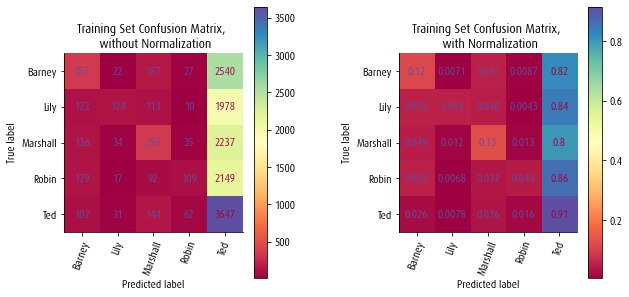

Cohen's Kappa Score for Training Set:
0.071
Matthew's Correlation Coefficient for Training Set:
0.114
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.39      0.10      0.16      1529
        Lily       0.47      0.04      0.08      1156
    Marshall       0.39      0.11      0.17      1377
       Robin       0.42      0.04      0.07      1229
         Ted       0.29      0.92      0.44      1963

    accuracy                           0.30      7254
   macro avg       0.39      0.24      0.18      7254
weighted avg       0.38      0.30      0.21      7254



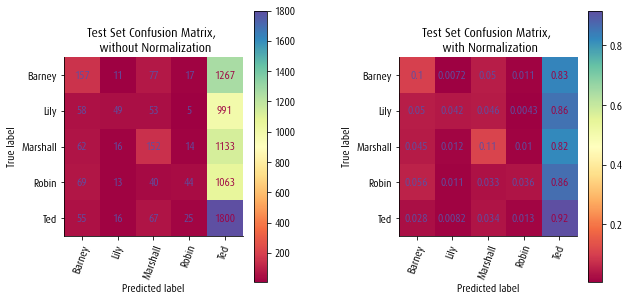

Cohen's Kappa Score for Test Set:
0.059
Matthew's Correlation Coefficient for Test Set:
0.098


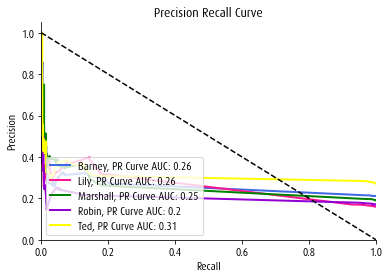

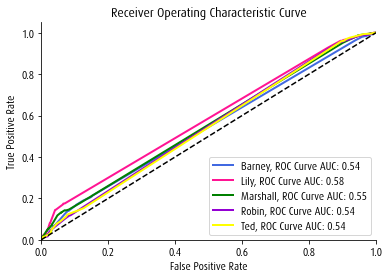

In [20]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

ABpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', AdaBoostClassifier()), 
]) #Creating adaboost pipeline with count vectorizer

ABpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(ABpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #evaluating training AB CV model

confmat_and_classrep(ABpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #evaluating test AB CV Model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = ABpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #building roc curves for each character

basescores_df.loc['11'] = pd.Series({'Model Name': 'ABCV', 'Accuracy Score': 0.30, 'Precision Score': 0.39, 
                                    'Recall Score': 0.24, 'F1 Score': 0.18, "Cohen's Kappa Score": 0.059, 
                                    "Matthew's Correlation Coefficient": 0.098, 'Barn PRC': 0.26, 'Lily PRC': 0.26, 
                                   'Mar PRC': 0.25, 'Rob PRC': 0.20, 'Ted PRC': 0.31, 'Barn ROC': 0.54, 
                                   'Lily ROC': 0.58, 'Mar ROC': 0.55, 'Rob ROC': 0.54, 'Ted ROC': 0.54}) #Inputting

### AdaBoost using TF-IDF Vectorizer

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.40      0.13      0.19      3103
        Lily       0.47      0.14      0.21      2347
    Marshall       0.42      0.10      0.16      2795
       Robin       0.48      0.04      0.08      2496
         Ted       0.29      0.89      0.44      3986

    accuracy                           0.31     14727
   macro avg       0.41      0.26      0.22     14727
weighted avg       0.40      0.31      0.24     14727



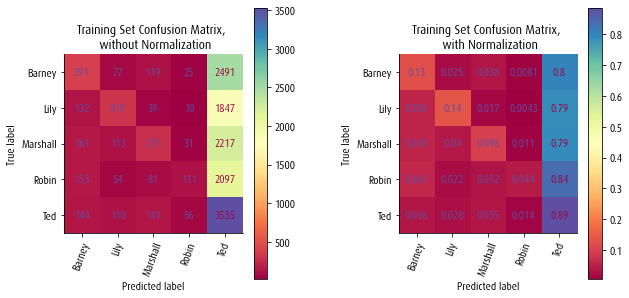

Cohen's Kappa Score for Training Set:
0.078
Matthew's Correlation Coefficient for Training Set:
0.118
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.38      0.12      0.18      1529
        Lily       0.39      0.11      0.17      1156
    Marshall       0.42      0.10      0.16      1377
       Robin       0.40      0.03      0.06      1229
         Ted       0.29      0.88      0.43      1963

    accuracy                           0.31      7254
   macro avg       0.38      0.25      0.20      7254
weighted avg       0.37      0.31      0.22      7254



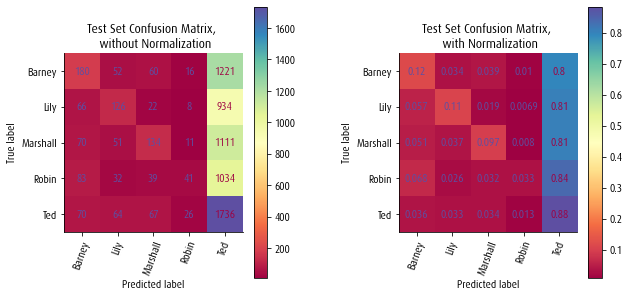

Cohen's Kappa Score for Test Set:
0.066
Matthew's Correlation Coefficient for Test Set:
0.1


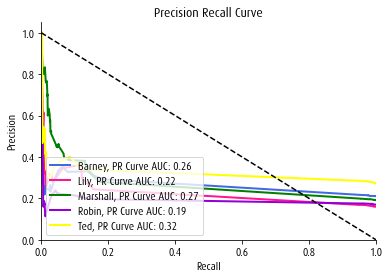

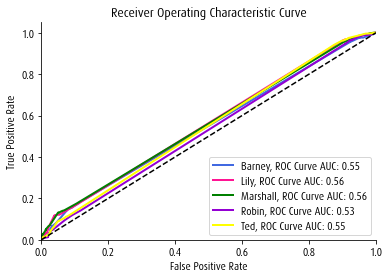

In [21]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

ABpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', AdaBoostClassifier()), 
]) #Creating adaboost pipeline with tfidf vectorizer

ABpipelineTF.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(ABpipelineTF, X_train, y_train_enc, le.classes_, 'Training') #evaluating training AB TF model

confmat_and_classrep(ABpipelineTF, X_test, y_test_enc, le.classes_, 'Test') #evaluating test AB TF model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = ABpipelineTF.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #building roc curves for each character

basescores_df.loc['12'] = pd.Series({'Model Name': 'ABTF', 'Accuracy Score': 0.31, 'Precision Score': 0.38, 
                                    'Recall Score': 0.25, 'F1 Score': 0.20, "Cohen's Kappa Score": 0.066, 
                                    "Matthew's Correlation Coefficient": 0.100, 'Barn PRC': 0.26, 'Lily PRC': 0.22, 
                                   'Mar PRC': 0.27, 'Rob PRC': 0.19, 'Ted PRC': 0.32, 'Barn ROC': 0.55, 
                                   'Lily ROC': 0.56, 'Mar ROC': 0.56, 'Rob ROC': 0.53, 'Ted ROC': 0.55}) #Inputting

We've finished our baseline models! Let's compare them.

# Comparing Baseline Models

We're going to look at our final baseline model scores table we created throughout this notebook and sort it by Cohen's Kappa Score. While we could look at accuracy, this dataset is imbalanced because some characters have more lines than others, and that's not something we can balance out. Cohen's Kappa score evaluates multi-class classifiers on imbalanced datasets. We're looking for a score close to 1; the closer a score is to 1, the better the classifier is.

In [22]:
basescores_df.sort_values(by = ["Cohen's Kappa Score"], ascending = False) #Comparing baseline models

Model Name Accuracy Score Precision Score Recall Score F1 Score  \
1    LogRegCV           0.32            0.31         0.29     0.29   
2    LogRegTF           0.32            0.31         0.29     0.28   
3       MNBCV           0.32            0.33         0.28     0.27   
8        RFTF           0.31             0.3         0.28     0.28   
7        RFCV            0.3            0.29         0.28     0.28   
9        DTCV           0.28            0.27         0.26     0.26   
4       MNBTF           0.31            0.35         0.26     0.22   
10       DTTF           0.27            0.26         0.26     0.25   
12       ABTF           0.31            0.38         0.25      0.2   
11       ABCV            0.3            0.39         0.24     0.18   
5       KNNCV           0.23            0.23         0.23     0.23   
6       KNNCV           0.24            0.22         0.22     0.22   

   Cohen's Kappa Score Matthew's Correlation Coefficient Barn PRC Lily PRC  \
1                0.121                             0.124     0.33     0.26   
2                0.116                             0.121     0.32     0.26   
3                 0.11                             0.121     0.35     0.25   
8                0.103                             0.106      0.3     0.23   
7                0.098                             0.099     0.28     0.23   
9                0.079                              0.08     0.32     0.25   
4                0.078                             0.103     0.32     0.25   
10               0.071                             0.072     0.34     0.25   
12               0.066                               0.1     0.26     0.22   
11               0.059                             0.098     0.26     0.26   
5                0.036                             0.036     0.23     0.19   
6                 0.03                              0.03     0.24     0.18   

   Mar PRC Rob PRC Ted PRC Barn ROC Lily ROC Mar ROC Rob ROC Ted ROC  
1     0.27    0.24    0.36     0.62     0.62     0.6     0.6    0.61  
2     0.27    0.23    0.36     0.62     0.61     0.6    0.59     0.6  
3     0.28    0.25    0.35     0.62     0.61     0.6    0.61     0.6  
8     0.26    0.22    0.34     0.59      0.6    0.59    0.59    0.58  
7     0.25    0.22    0.33     0.59     0.59    0.58    0.58    0.58  
9     0.28    0.25    0.38     0.56     0.55    0.54    0.56    0.56  
4     0.27    0.23    0.36     0.62     0.61     0.6    0.59     0.6  
10    0.29    0.25    0.39     0.55     0.54    0.54    0.55    0.54  
12    0.27    0.19    0.32     0.55     0.56    0.56    0.53    0.55  
11    0.25     0.2    0.31     0.54     0.58    0.55    0.54    0.54  
5     0.21    0.19    0.29     0.52     0.53    0.52    0.53    0.53  
6     0.22    0.17     0.3     0.53     0.52    0.52    0.51    0.52

While the Cohen's Kappa scores vary, the accuracy scores are also very close. In general, the models were overfitting to the training set and we're really seeing that with the precision recall curves; most of them are not good classifiers.

The top five baseline models are:

* Logistic Regression using Count Vectorizer: Cohen's Kappa = 0.121; Accuracy = 0.32
* Logistic Regression using TF-IDF Vectorizer: Cohen's Kappa = 0.116; Accuracy = 0.32
* Multinomial Naive Bayes using Count Vectorizer: Cohen's Kappa = 0.110; Accuracy = 0.32
* Random Forest using TF-IDF Vectorizer: Cohen's Kappa = 0.103; Accuracy = 0.31
* Random Forest using Count Vectorizer: Cohen's Kappa = 0.098; Accuracy = 0.30

It's worth noting that while these have the highest Cohen's Kappa scores out of all the baseline models, we would normally want these numbers to be closer to 1. We will tune these models though and hopefully raise these numbers.

# Tuning Models

For each logistic regression model, I'm going to set the class weight equal to balanced. I'm also going to try different values for C (0.5 and 1e50), then let's try these new values of C with class weight equal to balanced. This means each logistic regression/vectorizer combo will have seven tuned models (our subtotal right now is 10 tuned models).

For the multinomial naive bayes model, we'll try three different values for alpha (0.001, 0.01, and 0.1). This means the multinomial naive bayes model will be tuned three times (our subtotal now is 13 tuned models).

For each random forest model, we'll first try setting class weight equal to balanced. Let's also separately try a few different values for the number of estimators (10 and 50), then let's try these new values with class weight equal to balanced. This means each random forest/vectorizer combo will have five tuned models (our total will be 23 tuned models).

We'll again create a dataframe to compare all the scores in order to determine the best model.

In [23]:
tunedscores = pd.DataFrame(columns = ['Model Name', 'Accuracy Score', 'Precision Score', 'Recall Score', 
                                        'F1 Score', "Cohen's Kappa Score", "Matthew's Correlation Coefficient", 
                                       'Barn PRC', 'Lily PRC', 'Mar PRC', 'Rob PRC', 'Ted PRC', 'Barn ROC', 
                                       'Lily ROC', 'Mar ROC', 'Rob ROC', 'Ted ROC'], 
                         index = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', 
                                 '15', '16', '17', '18', '19', '20', '21', '22', '23'])
tunedscores.head() #Checking to make sure df was created

Model Name Accuracy Score Precision Score Recall Score F1 Score  \
1        NaN            NaN             NaN          NaN      NaN   
2        NaN            NaN             NaN          NaN      NaN   
3        NaN            NaN             NaN          NaN      NaN   
4        NaN            NaN             NaN          NaN      NaN   
5        NaN            NaN             NaN          NaN      NaN   

  Cohen's Kappa Score Matthew's Correlation Coefficient Barn PRC Lily PRC  \
1                 NaN                               NaN      NaN      NaN   
2                 NaN                               NaN      NaN      NaN   
3                 NaN                               NaN      NaN      NaN   
4                 NaN                               NaN      NaN      NaN   
5                 NaN                               NaN      NaN      NaN   

  Mar PRC Rob PRC Ted PRC Barn ROC Lily ROC Mar ROC Rob ROC Ted ROC  
1     NaN     NaN     NaN      NaN      NaN     NaN     NaN     NaN  
2     NaN     NaN     NaN      NaN      NaN     NaN     NaN     NaN  
3     NaN     NaN     NaN      NaN      NaN     NaN     NaN     NaN  
4     NaN     NaN     NaN      NaN      NaN     NaN     NaN     NaN  
5     NaN     NaN     NaN      NaN      NaN     NaN     NaN     NaN

## Logistic Regression using Count Vectorizer

We'll be tuning five models:

* Class Weight = Balanced
* C = 0.5
* C = 1e50
* Class Weight = Balanced, C = 0.5
* Class Weight = Balanced, C = 1e50

I'll be doing the same for the Logistic Regression models using the TF-IDF Vectorizer as well.

### Tuned Model 1: Class Weight = Balanced

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.76      0.65      0.70      3103
        Lily       0.62      0.69      0.65      2347
    Marshall       0.67      0.64      0.66      2795
       Robin       0.51      0.71      0.59      2496
         Ted       0.72      0.59      0.65      3986

    accuracy                           0.65     14727
   macro avg       0.66      0.66      0.65     14727
weighted avg       0.67      0.65      0.65     14727



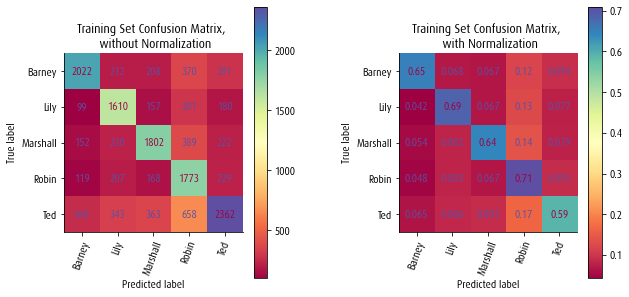

Cohen's Kappa Score for Training Set:
0.561
Matthew's Correlation Coefficient for Training Set:
0.564
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.34      0.27      0.30      1529
        Lily       0.26      0.28      0.27      1156
    Marshall       0.28      0.27      0.28      1377
       Robin       0.22      0.35      0.27      1229
         Ted       0.37      0.29      0.33      1963

    accuracy                           0.29      7254
   macro avg       0.30      0.29      0.29      7254
weighted avg       0.31      0.29      0.29      7254



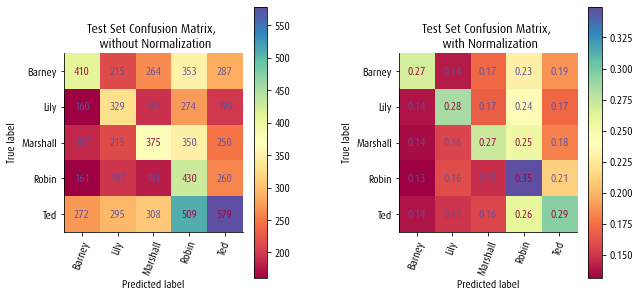

Cohen's Kappa Score for Test Set:
0.116
Matthew's Correlation Coefficient for Test Set:
0.117


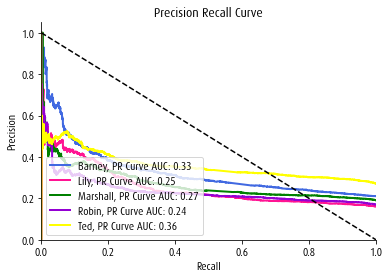

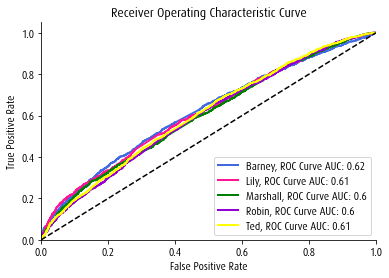

In [24]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T1LRpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(class_weight = 'balanced')), 
]) #Creating Logistic Regression pipeline with count vectorizer

T1LRpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(T1LRpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #Evaluating train 1st tuned model

confmat_and_classrep(T1LRpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test 1st tuned model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T1LRpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each character

tunedscores.loc['1'] = pd.Series({'Model Name': 'T1LRCV', 'Accuracy Score': 0.29, 'Precision Score': 0.30, 
                                    'Recall Score': 0.29, 'F1 Score': 0.29, "Cohen's Kappa Score": 0.116, 
                                    "Matthew's Correlation Coefficient": 0.117, 'Barn PRC': 0.33, 'Lily PRC': 0.25, 
                                   'Mar PRC': 0.27, 'Rob PRC': 0.24, 'Ted PRC': 0.36, 'Barn ROC': 0.62, 
                                   'Lily ROC': 0.61, 'Mar ROC': 0.60, 'Rob ROC': 0.60, 'Ted ROC': 0.61}) #Inputting

### Tuned Model 2: C = 0.5

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.70      0.62      0.66      3103
        Lily       0.76      0.49      0.59      2347
    Marshall       0.72      0.54      0.62      2795
       Robin       0.71      0.46      0.56      2496
         Ted       0.50      0.85      0.63      3986

    accuracy                           0.62     14727
   macro avg       0.68      0.59      0.61     14727
weighted avg       0.66      0.62      0.62     14727



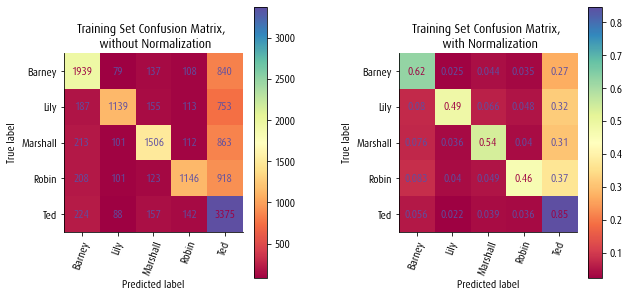

Cohen's Kappa Score for Training Set:
0.507
Matthew's Correlation Coefficient for Training Set:
0.523
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.34      0.29      0.31      1529
        Lily       0.34      0.19      0.25      1156
    Marshall       0.31      0.23      0.26      1377
       Robin       0.27      0.17      0.21      1229
         Ted       0.33      0.60      0.42      1963

    accuracy                           0.32      7254
   macro avg       0.32      0.29      0.29      7254
weighted avg       0.32      0.32      0.31      7254



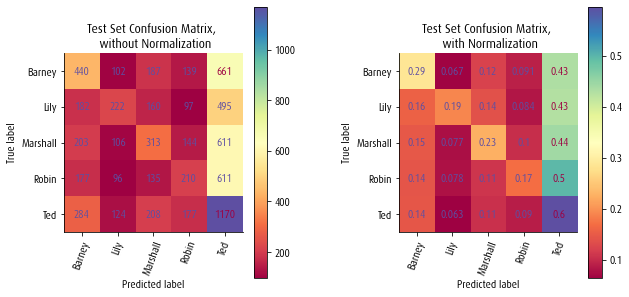

Cohen's Kappa Score for Test Set:
0.125
Matthew's Correlation Coefficient for Test Set:
0.13


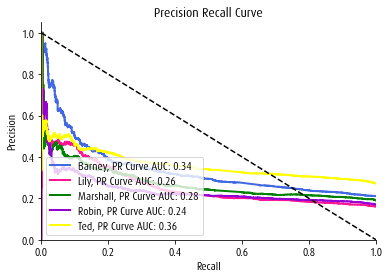

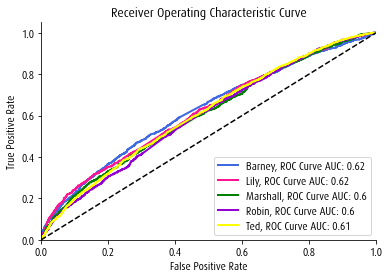

In [25]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T2LRpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 0.5)), 
]) #Creating Logistic Regression pipeline with count vectorizer

T2LRpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(T2LRpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR CV Model

confmat_and_classrep(T2LRpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test 1st tuned model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T2LRpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each character

tunedscores.loc['2'] = pd.Series({'Model Name': 'T2LRCV', 'Accuracy Score': 0.32, 'Precision Score': 0.32, 
                                    'Recall Score': 0.29, 'F1 Score': 0.29, "Cohen's Kappa Score": 0.125, 
                                    "Matthew's Correlation Coefficient": 0.130, 'Barn PRC': 0.34, 'Lily PRC': 0.26, 
                                   'Mar PRC': 0.28, 'Rob PRC': 0.24, 'Ted PRC': 0.36, 'Barn ROC': 0.62, 
                                   'Lily ROC': 0.62, 'Mar ROC': 0.60, 'Rob ROC': 0.60, 'Ted ROC': 0.61}) #Inputting

### Tuned Model 3: C = 1e50

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.83      0.73      0.77      3103
        Lily       0.80      0.68      0.73      2347
    Marshall       0.78      0.68      0.72      2795
       Robin       0.77      0.64      0.70      2496
         Ted       0.61      0.84      0.71      3986

    accuracy                           0.73     14727
   macro avg       0.76      0.71      0.73     14727
weighted avg       0.75      0.73      0.73     14727



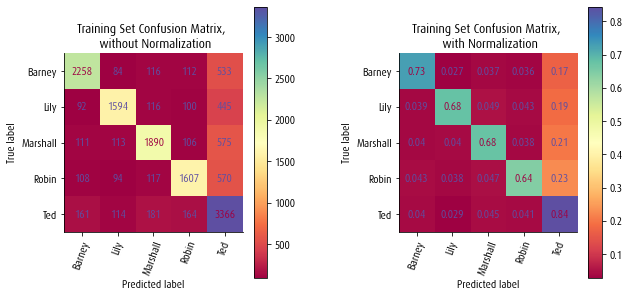

Cohen's Kappa Score for Training Set:
0.652
Matthew's Correlation Coefficient for Training Set:
0.658
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.33      0.28      0.30      1529
        Lily       0.28      0.23      0.25      1156
    Marshall       0.28      0.23      0.26      1377
       Robin       0.23      0.20      0.21      1229
         Ted       0.33      0.48      0.39      1963

    accuracy                           0.30      7254
   macro avg       0.29      0.28      0.28      7254
weighted avg       0.30      0.30      0.29      7254



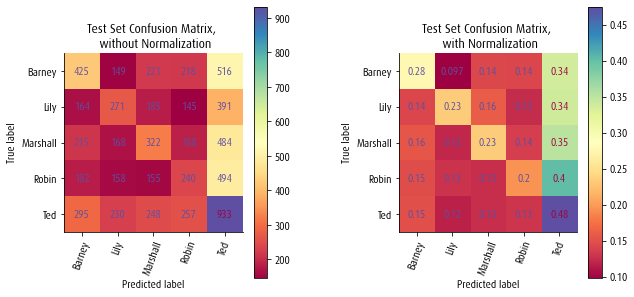

Cohen's Kappa Score for Test Set:
0.108
Matthew's Correlation Coefficient for Test Set:
0.109


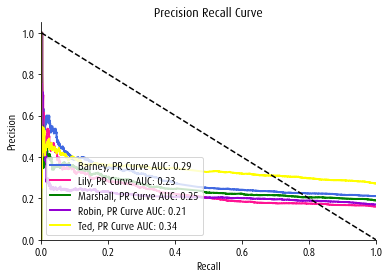

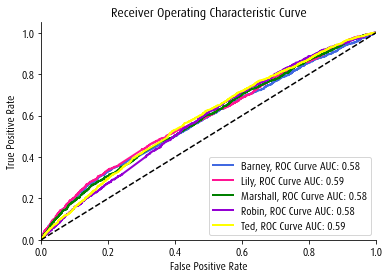

In [26]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T3LRpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 1e50)), 
]) #Creating Logistic Regression pipeline with count vectorizer

T3LRpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(T3LRpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR CV Model

confmat_and_classrep(T3LRpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test 1st tuned model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T3LRpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each character

tunedscores.loc['3'] = pd.Series({'Model Name': 'T3LRCV', 'Accuracy Score': 0.30, 'Precision Score': 0.29, 
                                    'Recall Score': 0.28, 'F1 Score': 0.28, "Cohen's Kappa Score": 0.108, 
                                    "Matthew's Correlation Coefficient": 0.109, 'Barn PRC': 0.29, 'Lily PRC': 0.23, 
                                   'Mar PRC': 0.25, 'Rob PRC': 0.21, 'Ted PRC': 0.34, 'Barn ROC': 0.58, 
                                   'Lily ROC': 0.59, 'Mar ROC': 0.58, 'Rob ROC': 0.58, 'Ted ROC': 0.59}) #Inputting

### Tuned Model 4: Class Weight = Balanced; C = 0.5

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.71      0.61      0.66      3103
        Lily       0.58      0.65      0.61      2347
    Marshall       0.63      0.61      0.62      2795
       Robin       0.48      0.67      0.56      2496
         Ted       0.69      0.55      0.61      3986

    accuracy                           0.61     14727
   macro avg       0.62      0.62      0.61     14727
weighted avg       0.63      0.61      0.61     14727



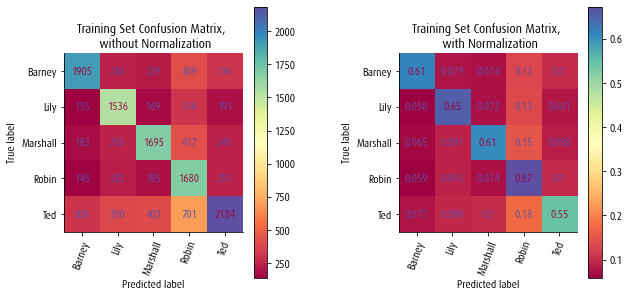

Cohen's Kappa Score for Training Set:
0.513
Matthew's Correlation Coefficient for Training Set:
0.516
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.35      0.28      0.31      1529
        Lily       0.26      0.29      0.27      1156
    Marshall       0.29      0.27      0.28      1377
       Robin       0.23      0.36      0.28      1229
         Ted       0.38      0.29      0.33      1963

    accuracy                           0.30      7254
   macro avg       0.30      0.30      0.29      7254
weighted avg       0.31      0.30      0.30      7254



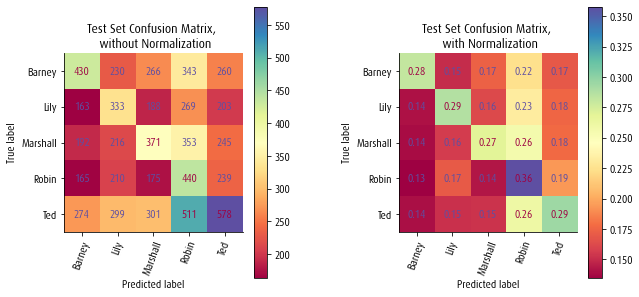

Cohen's Kappa Score for Test Set:
0.121
Matthew's Correlation Coefficient for Test Set:
0.122


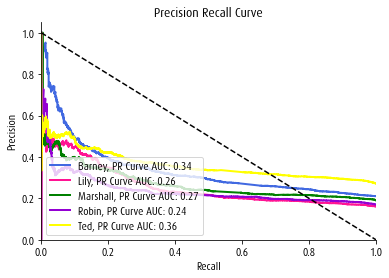

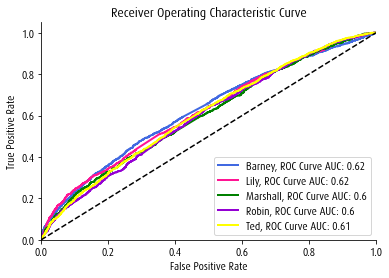

In [27]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T4LRpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 0.5, class_weight = 'balanced')), 
]) #Creating Logistic Regression pipeline with count vectorizer

T4LRpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(T4LRpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR CV Model

confmat_and_classrep(T4LRpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test 1st tuned model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T4LRpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each character

tunedscores.loc['4'] = pd.Series({'Model Name': 'T4LRCV', 'Accuracy Score': 0.30, 'Precision Score': 0.30, 
                                    'Recall Score': 0.30, 'F1 Score': 0.29, "Cohen's Kappa Score": 0.121, 
                                    "Matthew's Correlation Coefficient": 0.122, 'Barn PRC': 0.34, 'Lily PRC': 0.26, 
                                   'Mar PRC': 0.27, 'Rob PRC': 0.24, 'Ted PRC': 0.36, 'Barn ROC': 0.62, 
                                   'Lily ROC': 0.62, 'Mar ROC': 0.60, 'Rob ROC': 0.60, 'Ted ROC': 0.61}) #Inputting

### Tuned Model 5: Class Weight = Balanced; C = 1e50

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.81      0.74      0.77      3103
        Lily       0.72      0.72      0.72      2347
    Marshall       0.76      0.69      0.72      2795
       Robin       0.53      0.82      0.65      2496
         Ted       0.81      0.65      0.72      3986

    accuracy                           0.72     14727
   macro avg       0.73      0.72      0.72     14727
weighted avg       0.74      0.72      0.72     14727



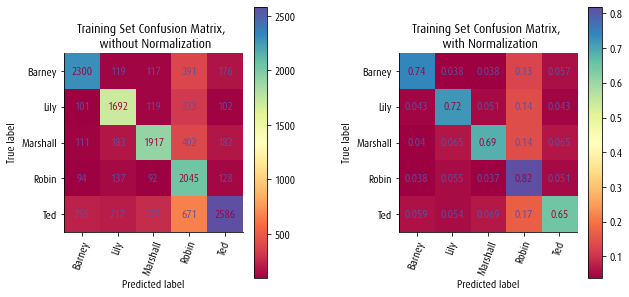

Cohen's Kappa Score for Training Set:
0.644
Matthew's Correlation Coefficient for Training Set:
0.649
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.32      0.28      0.30      1529
        Lily       0.26      0.26      0.26      1156
    Marshall       0.28      0.25      0.26      1377
       Robin       0.22      0.36      0.27      1229
         Ted       0.35      0.27      0.30      1963

    accuracy                           0.28      7254
   macro avg       0.28      0.28      0.28      7254
weighted avg       0.29      0.28      0.28      7254



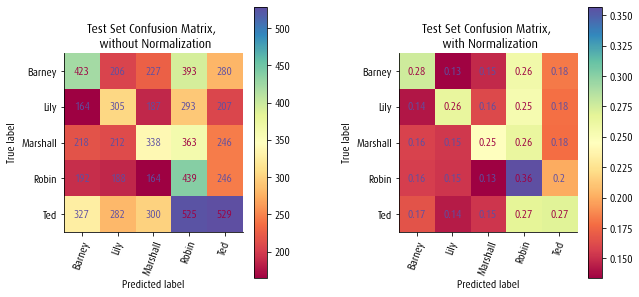

Cohen's Kappa Score for Test Set:
0.101
Matthew's Correlation Coefficient for Test Set:
0.102


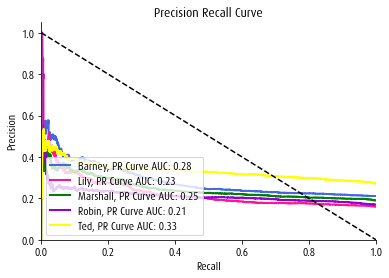

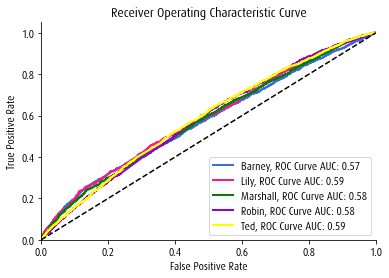

In [28]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T5LRpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 1e50, class_weight = 'balanced')), 
]) #Creating Logistic Regression pipeline with count vectorizer

T5LRpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(T5LRpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR CV Model

confmat_and_classrep(T5LRpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test 1st tuned model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T5LRpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each character

tunedscores.loc['5'] = pd.Series({'Model Name': 'T5LRCV', 'Accuracy Score': 0.28, 'Precision Score': 0.28, 
                                    'Recall Score': 0.28, 'F1 Score': 0.28, "Cohen's Kappa Score": 0.101, 
                                    "Matthew's Correlation Coefficient": 0.102, 'Barn PRC': 0.28, 'Lily PRC': 0.23, 
                                   'Mar PRC': 0.25, 'Rob PRC': 0.21, 'Ted PRC': 0.33, 'Barn ROC': 0.57, 
                                   'Lily ROC': 0.59, 'Mar ROC': 0.58, 'Rob ROC': 0.58, 'Ted ROC': 0.59}) #Inputting

## Logistic Regression using TF-IDF Vectorizer

### Tuning Model 6: Class Weight = Balanced

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.66      0.64      0.65      3103
        Lily       0.58      0.63      0.60      2347
    Marshall       0.61      0.59      0.60      2795
       Robin       0.56      0.60      0.58      2496
         Ted       0.61      0.59      0.60      3986

    accuracy                           0.61     14727
   macro avg       0.61      0.61      0.61     14727
weighted avg       0.61      0.61      0.61     14727



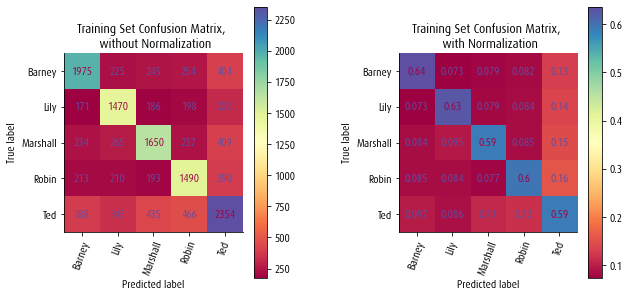

Cohen's Kappa Score for Training Set:
0.505
Matthew's Correlation Coefficient for Training Set:
0.505
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.33      0.30      0.32      1529
        Lily       0.26      0.28      0.27      1156
    Marshall       0.28      0.26      0.27      1377
       Robin       0.25      0.27      0.26      1229
         Ted       0.34      0.35      0.35      1963

    accuracy                           0.30      7254
   macro avg       0.29      0.29      0.29      7254
weighted avg       0.30      0.30      0.30      7254



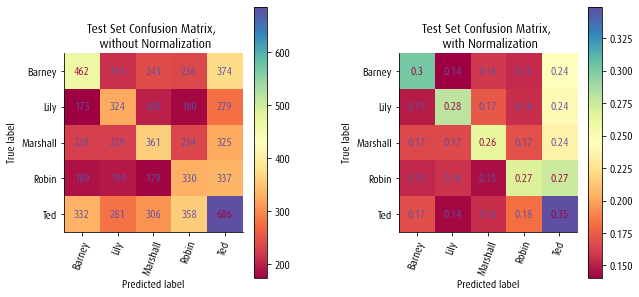

Cohen's Kappa Score for Test Set:
0.115
Matthew's Correlation Coefficient for Test Set:
0.115


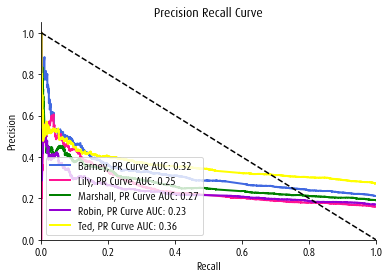

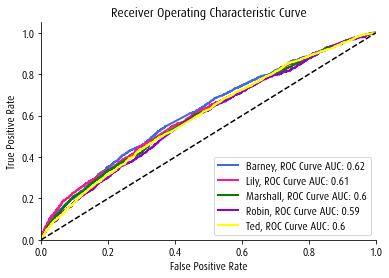

In [29]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T6LRpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(class_weight = 'balanced')), 
]) #Creating Logistic Regression pipeline with count vectorizer

T6LRpipelineTF.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(T6LRpipelineTF, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR TF Model

confmat_and_classrep(T6LRpipelineTF, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test 1st tuned model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T6LRpipelineTF.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each character

tunedscores.loc['6'] = pd.Series({'Model Name': 'T6LRTF', 'Accuracy Score': 0.30, 'Precision Score': 0.29, 
                                    'Recall Score': 0.29, 'F1 Score': 0.29, "Cohen's Kappa Score": 0.115, 
                                    "Matthew's Correlation Coefficient": 0.115, 'Barn PRC': 0.32, 'Lily PRC': 0.25, 
                                   'Mar PRC': 0.27, 'Rob PRC': 0.23, 'Ted PRC': 0.36, 'Barn ROC': 0.62, 
                                   'Lily ROC': 0.61, 'Mar ROC': 0.60, 'Rob ROC': 0.59, 'Ted ROC': 0.60}) #Inputting

### Tuned Model 7: C = 0.5

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.60      0.56      0.58      3103
        Lily       0.69      0.30      0.41      2347
    Marshall       0.63      0.43      0.51      2795
       Robin       0.65      0.30      0.41      2496
         Ted       0.44      0.84      0.57      3986

    accuracy                           0.53     14727
   macro avg       0.60      0.49      0.50     14727
weighted avg       0.58      0.53      0.51     14727



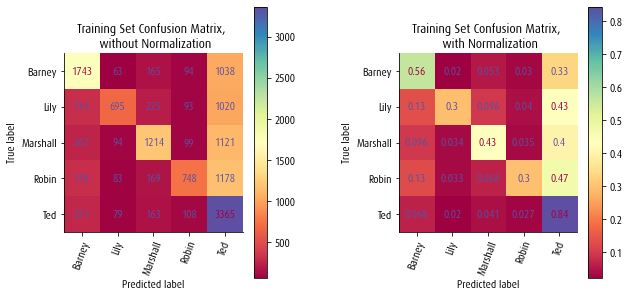

Cohen's Kappa Score for Training Set:
0.384
Matthew's Correlation Coefficient for Training Set:
0.408
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.34      0.29      0.31      1529
        Lily       0.36      0.14      0.20      1156
    Marshall       0.30      0.18      0.23      1377
       Robin       0.27      0.11      0.15      1229
         Ted       0.31      0.67      0.43      1963

    accuracy                           0.32      7254
   macro avg       0.32      0.28      0.26      7254
weighted avg       0.32      0.32      0.28      7254



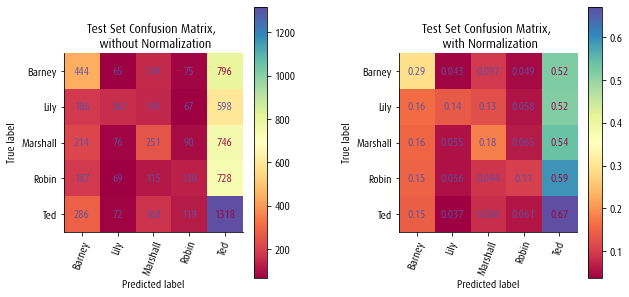

Cohen's Kappa Score for Test Set:
0.105
Matthew's Correlation Coefficient for Test Set:
0.115


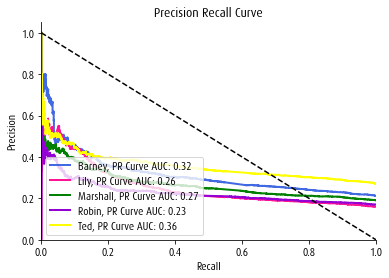

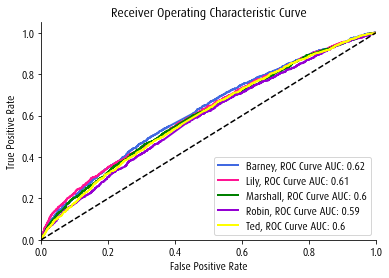

In [30]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T7LRpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 0.5)), 
]) #Creating Logistic Regression pipeline with count vectorizer

T7LRpipelineTF.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(T7LRpipelineTF, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR TF Model

confmat_and_classrep(T7LRpipelineTF, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test tuned model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T7LRpipelineTF.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each character

tunedscores.loc['7'] = pd.Series({'Model Name': 'T7LRTF', 'Accuracy Score': 0.32, 'Precision Score': 0.32, 
                                    'Recall Score': 0.28, 'F1 Score': 0.26, "Cohen's Kappa Score": 0.105, 
                                    "Matthew's Correlation Coefficient": 0.115, 'Barn PRC': 0.32, 'Lily PRC': 0.26, 
                                   'Mar PRC': 0.27, 'Rob PRC': 0.23, 'Ted PRC': 0.36, 'Barn ROC': 0.62, 
                                   'Lily ROC': 0.61, 'Mar ROC': 0.60, 'Rob ROC': 0.59, 'Ted ROC': 0.60}) #Inputting

### Tuned Model 8: C = 1e50

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.75      0.71      0.73      3103
        Lily       0.73      0.64      0.68      2347
    Marshall       0.70      0.65      0.68      2795
       Robin       0.70      0.64      0.67      2496
         Ted       0.63      0.76      0.69      3986

    accuracy                           0.69     14727
   macro avg       0.70      0.68      0.69     14727
weighted avg       0.70      0.69      0.69     14727



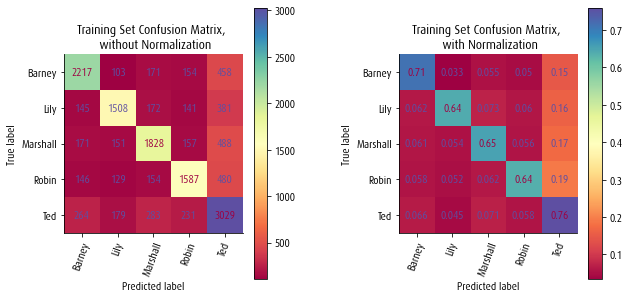

Cohen's Kappa Score for Training Set:
0.607
Matthew's Correlation Coefficient for Training Set:
0.608
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.32      0.30      0.31      1529
        Lily       0.26      0.23      0.24      1156
    Marshall       0.28      0.24      0.26      1377
       Robin       0.24      0.22      0.23      1229
         Ted       0.33      0.42      0.37      1963

    accuracy                           0.30      7254
   macro avg       0.29      0.28      0.28      7254
weighted avg       0.29      0.30      0.29      7254



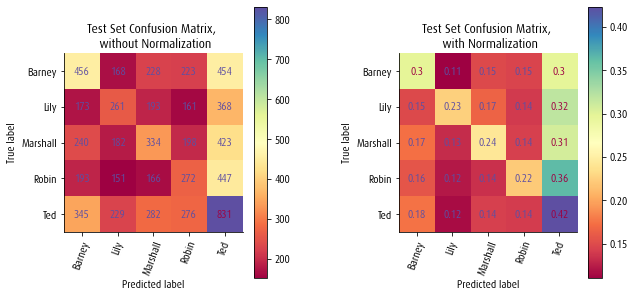

Cohen's Kappa Score for Test Set:
0.105
Matthew's Correlation Coefficient for Test Set:
0.105


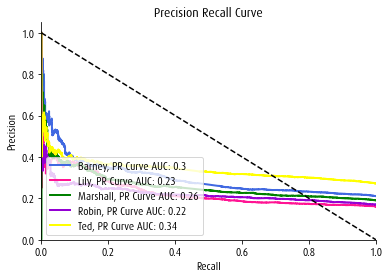

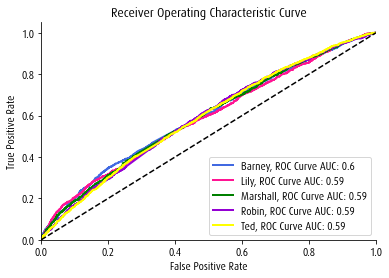

In [31]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T8LRpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 1e50)), 
]) #Creating Logistic Regression pipeline with count vectorizer

T8LRpipelineTF.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(T8LRpipelineTF, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR TF Model

confmat_and_classrep(T8LRpipelineTF, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test tuned model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T8LRpipelineTF.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each character

tunedscores.loc['8'] = pd.Series({'Model Name': 'T8LRTF', 'Accuracy Score': 0.30, 'Precision Score': 0.29, 
                                    'Recall Score': 0.28, 'F1 Score': 0.28, "Cohen's Kappa Score": 0.105, 
                                    "Matthew's Correlation Coefficient": 0.105, 'Barn PRC': 0.30, 'Lily PRC': 0.23, 
                                   'Mar PRC': 0.26, 'Rob PRC': 0.22, 'Ted PRC': 0.34, 'Barn ROC': 0.60, 
                                   'Lily ROC': 0.59, 'Mar ROC': 0.59, 'Rob ROC': 0.59, 'Ted ROC': 0.59}) #Inputting

### Tuned Model 9: Class Weight = Balanced; C = 0.5

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.61      0.59      0.60      3103
        Lily       0.54      0.59      0.56      2347
    Marshall       0.57      0.55      0.56      2795
       Robin       0.53      0.55      0.54      2496
         Ted       0.58      0.55      0.57      3986

    accuracy                           0.57     14727
   macro avg       0.56      0.57      0.57     14727
weighted avg       0.57      0.57      0.57     14727



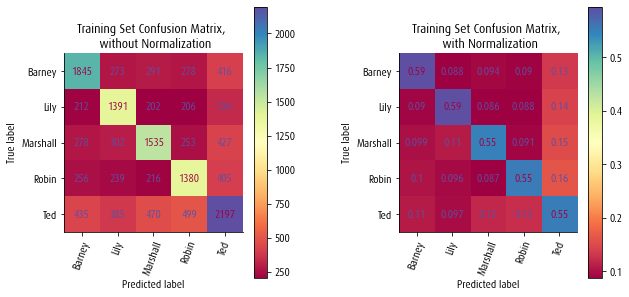

Cohen's Kappa Score for Training Set:
0.455
Matthew's Correlation Coefficient for Training Set:
0.455
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.32      0.30      0.31      1529
        Lily       0.26      0.29      0.27      1156
    Marshall       0.28      0.27      0.27      1377
       Robin       0.24      0.26      0.25      1229
         Ted       0.34      0.34      0.34      1963

    accuracy                           0.30      7254
   macro avg       0.29      0.29      0.29      7254
weighted avg       0.30      0.30      0.30      7254



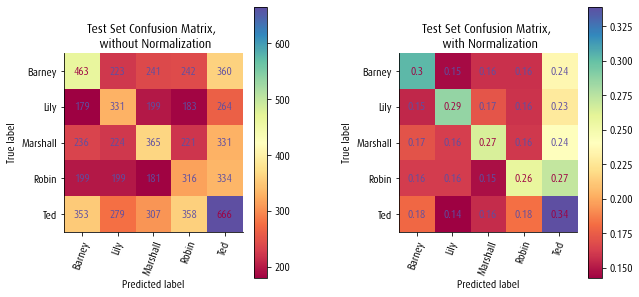

Cohen's Kappa Score for Test Set:
0.111
Matthew's Correlation Coefficient for Test Set:
0.111


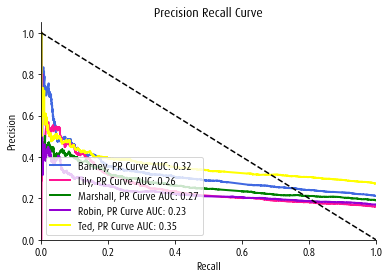

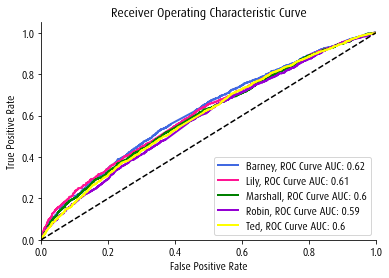

In [32]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T9LRpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 0.5, class_weight = 'balanced')), 
]) #Creating Logistic Regression pipeline with count vectorizer

T9LRpipelineTF.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(T9LRpipelineTF, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR CV Model

confmat_and_classrep(T9LRpipelineTF, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test 1st tuned model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T9LRpipelineTF.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each character

tunedscores.loc['9'] = pd.Series({'Model Name': 'T9LRTF', 'Accuracy Score': 0.30, 'Precision Score': 0.29, 
                                    'Recall Score': 0.29, 'F1 Score': 0.29, "Cohen's Kappa Score": 0.111, 
                                    "Matthew's Correlation Coefficient": 0.111, 'Barn PRC': 0.32, 'Lily PRC': 0.26, 
                                   'Mar PRC': 0.27, 'Rob PRC': 0.23, 'Ted PRC': 0.35, 'Barn ROC': 0.62, 
                                   'Lily ROC': 0.61, 'Mar ROC': 0.60, 'Rob ROC': 0.59, 'Ted ROC': 0.60}) #Inputting

### Tuned Model 10: Class Weight = Balanced; C = 1e50

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.79      0.69      0.74      3103
        Lily       0.63      0.75      0.68      2347
    Marshall       0.71      0.66      0.69      2795
       Robin       0.70      0.67      0.68      2496
         Ted       0.66      0.70      0.68      3986

    accuracy                           0.69     14727
   macro avg       0.70      0.69      0.69     14727
weighted avg       0.70      0.69      0.70     14727



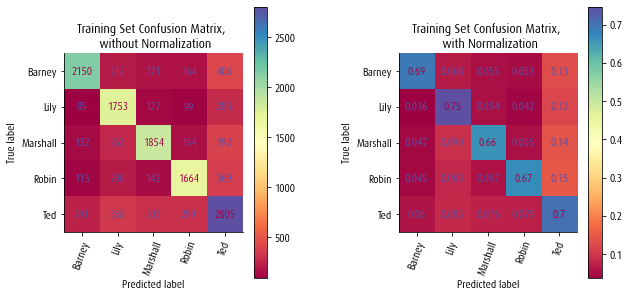

Cohen's Kappa Score for Training Set:
0.614
Matthew's Correlation Coefficient for Training Set:
0.615
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.32      0.26      0.29      1529
        Lily       0.24      0.28      0.26      1156
    Marshall       0.28      0.24      0.26      1377
       Robin       0.23      0.22      0.23      1229
         Ted       0.33      0.37      0.35      1963

    accuracy                           0.29      7254
   macro avg       0.28      0.28      0.28      7254
weighted avg       0.29      0.29      0.28      7254



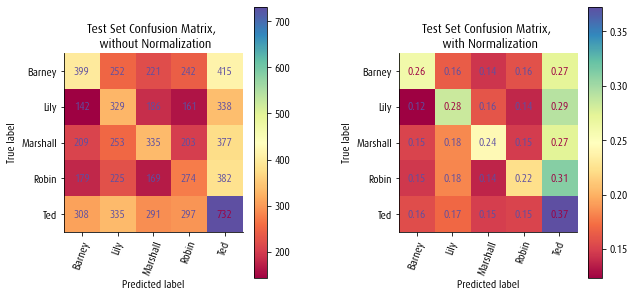

Cohen's Kappa Score for Test Set:
0.096
Matthew's Correlation Coefficient for Test Set:
0.096


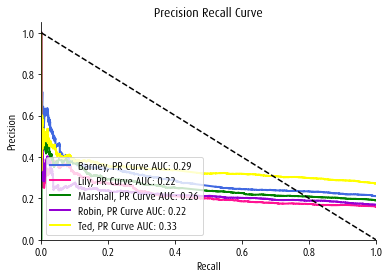

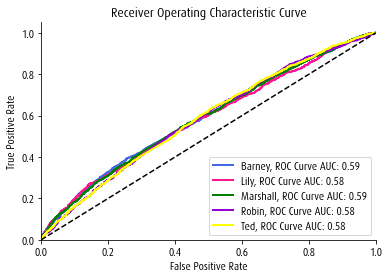

In [33]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T10LRpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 1e50, class_weight = 'balanced')), 
]) #Creating Logistic Regression pipeline with count vectorizer

T10LRpipelineTF.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(T10LRpipelineTF, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR CV Model

confmat_and_classrep(T10LRpipelineTF, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test 1st tuned model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T10LRpipelineTF.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each character

tunedscores.loc['10'] = pd.Series({'Model Name': 'T10LRTF', 'Accuracy Score': 0.29, 'Precision Score': 0.28, 
                                    'Recall Score': 0.28, 'F1 Score': 0.28, "Cohen's Kappa Score": 0.096, 
                                    "Matthew's Correlation Coefficient": 0.096, 'Barn PRC': 0.29, 'Lily PRC': 0.22, 
                                   'Mar PRC': 0.26, 'Rob PRC': 0.22, 'Ted PRC': 0.33, 'Barn ROC': 0.59, 
                                   'Lily ROC': 0.58, 'Mar ROC': 0.59, 'Rob ROC': 0.58, 'Ted ROC': 0.58}) #Inputting

## Multinomial Naive Bayes using Count Vectorizer

We'll be tuning three models:

* Alpha = 0.001
* Alpha = 0.01
* Alpha = 0.1

### Tuned Model 11: Alpha 0.001

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.71      0.61      0.66      3103
        Lily       0.68      0.58      0.62      2347
    Marshall       0.70      0.56      0.62      2795
       Robin       0.66      0.53      0.59      2496
         Ted       0.52      0.77      0.62      3986

    accuracy                           0.62     14727
   macro avg       0.66      0.61      0.62     14727
weighted avg       0.65      0.62      0.62     14727



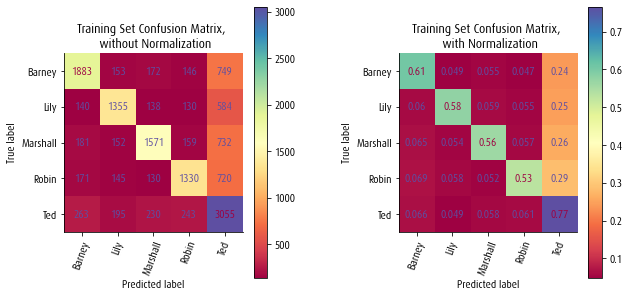

Cohen's Kappa Score for Training Set:
0.519
Matthew's Correlation Coefficient for Training Set:
0.526
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.33      0.27      0.30      1529
        Lily       0.31      0.23      0.26      1156
    Marshall       0.30      0.24      0.26      1377
       Robin       0.26      0.21      0.23      1229
         Ted       0.33      0.52      0.40      1963

    accuracy                           0.31      7254
   macro avg       0.31      0.29      0.29      7254
weighted avg       0.31      0.31      0.30      7254



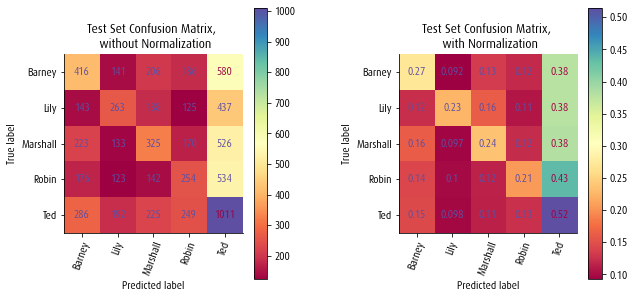

Cohen's Kappa Score for Test Set:
0.117
Matthew's Correlation Coefficient for Test Set:
0.12


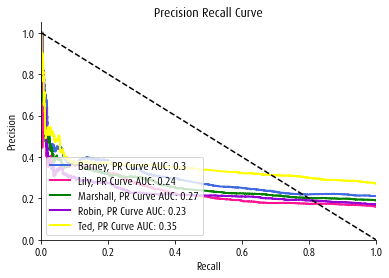

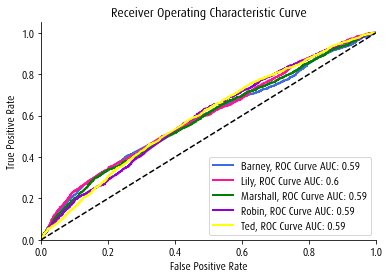

In [34]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T11MNBpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', MultinomialNB(alpha = 0.001)), 
]) #Creating Logistic Regression pipeline with count vectorizer

T11MNBpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(T11MNBpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR CV Model

confmat_and_classrep(T11MNBpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test 1st tuned model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T11MNBpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each character

tunedscores.loc['11'] = pd.Series({'Model Name': 'T11MNBCV', 'Accuracy Score': 0.31, 'Precision Score': 0.31, 
                                    'Recall Score': 0.29, 'F1 Score': 0.29, "Cohen's Kappa Score": 0.117, 
                                    "Matthew's Correlation Coefficient": 0.120, 'Barn PRC': 0.30, 'Lily PRC': 0.24, 
                                   'Mar PRC': 0.27, 'Rob PRC': 0.23, 'Ted PRC': 0.35, 'Barn ROC': 0.59, 
                                   'Lily ROC': 0.60, 'Mar ROC': 0.59, 'Rob ROC': 0.59, 'Ted ROC': 0.59}) #Inputting

### Tuned Model 12: Alpha = 0.01

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.71      0.61      0.66      3103
        Lily       0.68      0.58      0.62      2347
    Marshall       0.70      0.56      0.62      2795
       Robin       0.66      0.53      0.59      2496
         Ted       0.52      0.77      0.62      3986

    accuracy                           0.62     14727
   macro avg       0.66      0.61      0.62     14727
weighted avg       0.65      0.62      0.62     14727



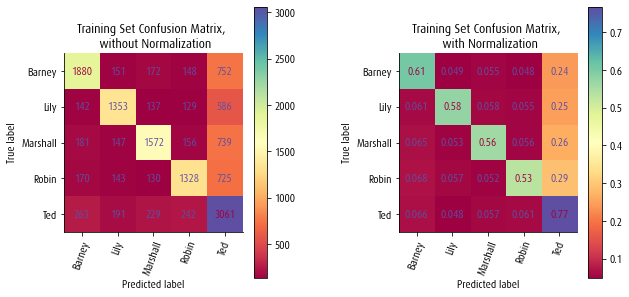

Cohen's Kappa Score for Training Set:
0.519
Matthew's Correlation Coefficient for Training Set:
0.526
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.34      0.27      0.30      1529
        Lily       0.31      0.23      0.26      1156
    Marshall       0.30      0.24      0.27      1377
       Robin       0.26      0.21      0.23      1229
         Ted       0.33      0.52      0.40      1963

    accuracy                           0.31      7254
   macro avg       0.31      0.29      0.29      7254
weighted avg       0.31      0.31      0.30      7254



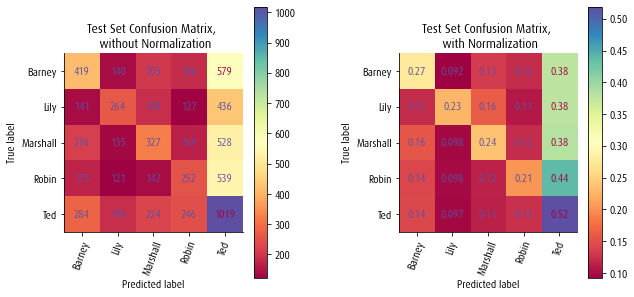

Cohen's Kappa Score for Test Set:
0.119
Matthew's Correlation Coefficient for Test Set:
0.122


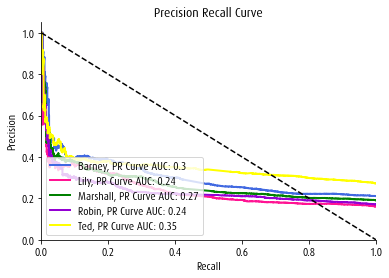

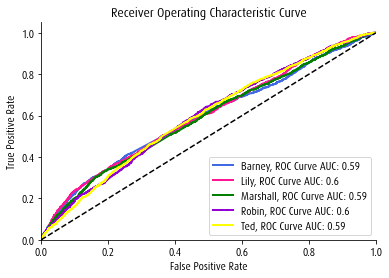

In [35]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T12MNBpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', MultinomialNB(alpha = 0.01)), 
]) #Creating Logistic Regression pipeline with count vectorizer

T12MNBpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(T12MNBpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR CV Model

confmat_and_classrep(T12MNBpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test 1st tuned model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T12MNBpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each character

tunedscores.loc['12'] = pd.Series({'Model Name': 'T12MNBCV', 'Accuracy Score': 0.31, 'Precision Score': 0.31, 
                                    'Recall Score': 0.29, 'F1 Score': 0.29, "Cohen's Kappa Score": 0.119, 
                                    "Matthew's Correlation Coefficient": 0.122, 'Barn PRC': 0.30, 'Lily PRC': 0.24, 
                                   'Mar PRC': 0.27, 'Rob PRC': 0.24, 'Ted PRC': 0.35, 'Barn ROC': 0.59, 
                                   'Lily ROC': 0.60, 'Mar ROC': 0.59, 'Rob ROC': 0.60, 'Ted ROC': 0.59}) #Inputting

### Tuned Model 13: Alpha = 0.1

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.70      0.60      0.65      3103
        Lily       0.70      0.56      0.62      2347
    Marshall       0.70      0.55      0.62      2795
       Robin       0.68      0.51      0.58      2496
         Ted       0.51      0.79      0.62      3986

    accuracy                           0.62     14727
   macro avg       0.66      0.60      0.62     14727
weighted avg       0.65      0.62      0.62     14727



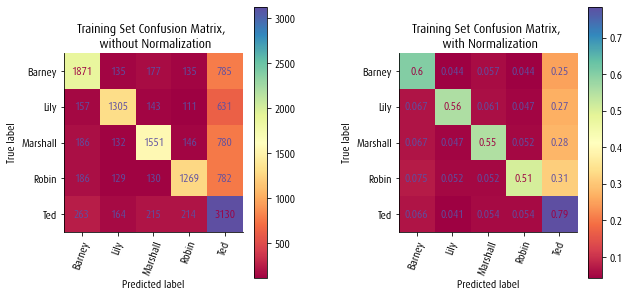

Cohen's Kappa Score for Training Set:
0.512
Matthew's Correlation Coefficient for Training Set:
0.521
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.34      0.27      0.30      1529
        Lily       0.30      0.21      0.25      1156
    Marshall       0.31      0.24      0.27      1377
       Robin       0.26      0.20      0.22      1229
         Ted       0.33      0.54      0.41      1963

    accuracy                           0.32      7254
   macro avg       0.31      0.29      0.29      7254
weighted avg       0.31      0.32      0.30      7254



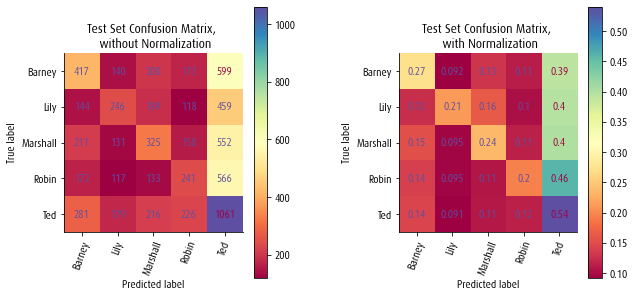

Cohen's Kappa Score for Test Set:
0.119
Matthew's Correlation Coefficient for Test Set:
0.122


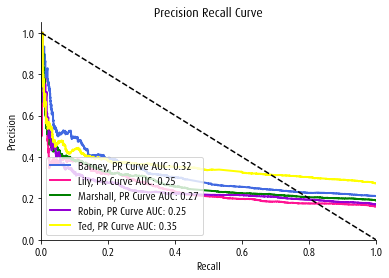

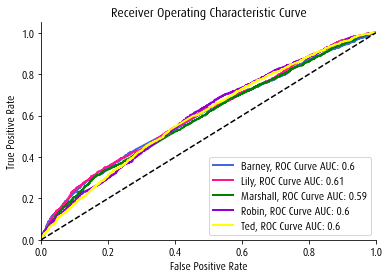

In [36]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T13MNBpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', MultinomialNB(alpha = 0.1)), 
]) #Creating Logistic Regression pipeline with count vectorizer

T13MNBpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(T13MNBpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR CV Model

confmat_and_classrep(T13MNBpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test 1st tuned model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T13MNBpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each character

tunedscores.loc['13'] = pd.Series({'Model Name': 'T13MNBCV', 'Accuracy Score': 0.32, 'Precision Score': 0.31, 
                                    'Recall Score': 0.29, 'F1 Score': 0.29, "Cohen's Kappa Score": 0.119, 
                                    "Matthew's Correlation Coefficient": 0.122, 'Barn PRC': 0.32, 'Lily PRC': 0.25, 
                                   'Mar PRC': 0.27, 'Rob PRC': 0.25, 'Ted PRC': 0.35, 'Barn ROC': 0.60, 
                                   'Lily ROC': 0.61, 'Mar ROC': 0.59, 'Rob ROC': 0.60, 'Ted ROC': 0.60}) #Inputting

## Random Forest using Count Vectorizer

We'll be tuning five models:

* Class Weight = Balanced
* Number of Estimators = 10
* Number of Estimators = 50
* Class Weight = Balanced; Number of Estimators = 10
* Class Weight = Balanced; Number of Estimators = 50

### Tuned Model 14: Class Weight = Balanced

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.95      0.88      0.91      3103
        Lily       0.90      0.88      0.89      2347
    Marshall       0.95      0.86      0.90      2795
       Robin       0.71      0.93      0.80      2496
         Ted       0.93      0.86      0.89      3986

    accuracy                           0.88     14727
   macro avg       0.89      0.88      0.88     14727
weighted avg       0.89      0.88      0.88     14727



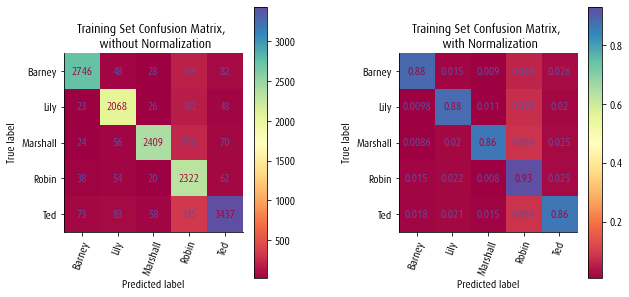

Cohen's Kappa Score for Training Set:
0.851
Matthew's Correlation Coefficient for Training Set:
0.853
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.31      0.27      0.29      1529
        Lily       0.26      0.26      0.26      1156
    Marshall       0.29      0.24      0.26      1377
       Robin       0.23      0.31      0.26      1229
         Ted       0.34      0.34      0.34      1963

    accuracy                           0.29      7254
   macro avg       0.28      0.28      0.28      7254
weighted avg       0.29      0.29      0.29      7254



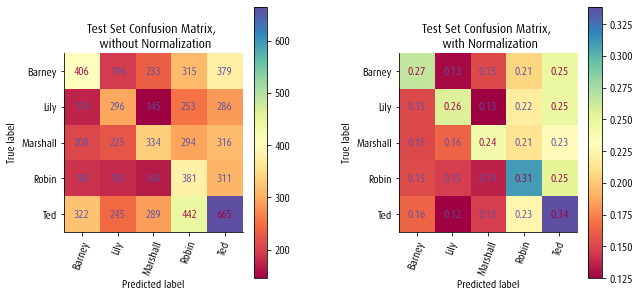

Cohen's Kappa Score for Test Set:
0.102
Matthew's Correlation Coefficient for Test Set:
0.103


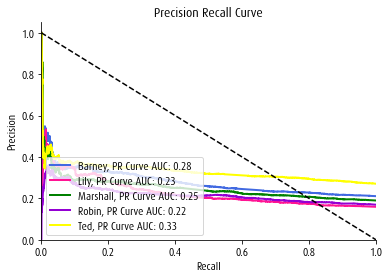

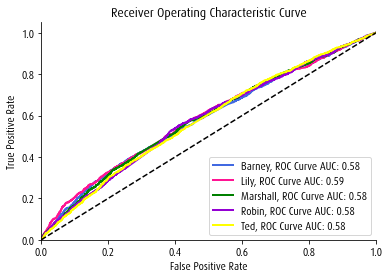

In [37]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T14RFpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier(class_weight = 'balanced')), 
]) #Creating Logistic Regression pipeline with count vectorizer

T14RFpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(T14RFpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR CV Model

confmat_and_classrep(T14RFpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test 1st tuned model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T14RFpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each character

tunedscores.loc['14'] = pd.Series({'Model Name': 'T14RFCV', 'Accuracy Score': 0.29, 'Precision Score': 0.28, 
                                    'Recall Score': 0.28, 'F1 Score': 0.28, "Cohen's Kappa Score": 0.100, 
                                    "Matthew's Correlation Coefficient": 0.101, 'Barn PRC': 0.28, 'Lily PRC': 0.23, 
                                   'Mar PRC': 0.25, 'Rob PRC': 0.22, 'Ted PRC': 0.33, 'Barn ROC': 0.59, 
                                   'Lily ROC': 0.59, 'Mar ROC': 0.58, 'Rob ROC': 0.58, 'Ted ROC': 0.57}) #Inputting

### Tuned Model 15: Number of Estimators = 10

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.92      0.88      0.90      3103
        Lily       0.93      0.85      0.89      2347
    Marshall       0.94      0.85      0.89      2795
       Robin       0.91      0.83      0.87      2496
         Ted       0.78      0.94      0.85      3986

    accuracy                           0.88     14727
   macro avg       0.90      0.87      0.88     14727
weighted avg       0.88      0.88      0.88     14727



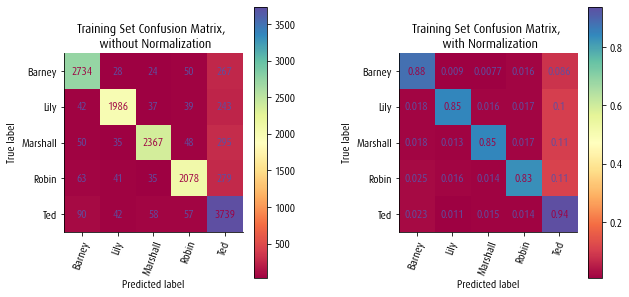

Cohen's Kappa Score for Training Set:
0.843
Matthew's Correlation Coefficient for Training Set:
0.845
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.29      0.26      0.27      1529
        Lily       0.25      0.23      0.24      1156
    Marshall       0.28      0.23      0.25      1377
       Robin       0.24      0.19      0.21      1229
         Ted       0.31      0.43      0.36      1963

    accuracy                           0.28      7254
   macro avg       0.27      0.27      0.27      7254
weighted avg       0.28      0.28      0.28      7254



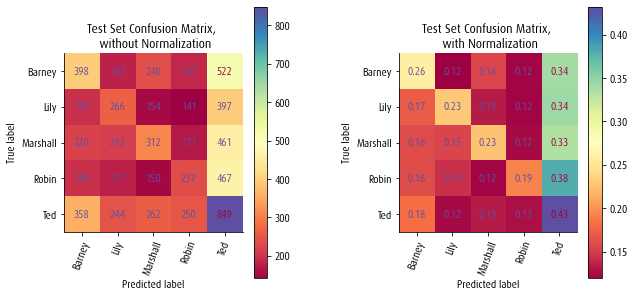

Cohen's Kappa Score for Test Set:
0.086
Matthew's Correlation Coefficient for Test Set:
0.087


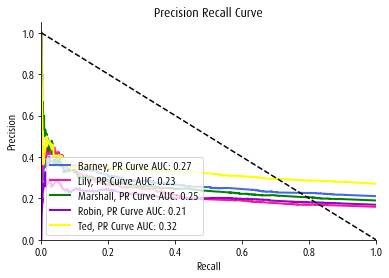

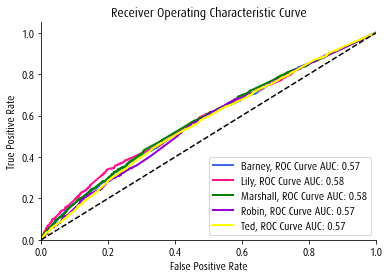

In [38]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T15RFpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier(n_estimators = 10)), 
]) #Creating Logistic Regression pipeline with count vectorizer

T15RFpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(T15RFpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR CV Model

confmat_and_classrep(T15RFpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test 1st tuned model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T15RFpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each character

tunedscores.loc['15'] = pd.Series({'Model Name': 'T15RFCV', 'Accuracy Score': 0.28, 'Precision Score': 0.27, 
                                    'Recall Score': 0.26, 'F1 Score': 0.26, "Cohen's Kappa Score": 0.080, 
                                    "Matthew's Correlation Coefficient": 0.081, 'Barn PRC': 0.27, 'Lily PRC': 0.21, 
                                   'Mar PRC': 0.24, 'Rob PRC': 0.21, 'Ted PRC': 0.33, 'Barn ROC': 0.57, 
                                   'Lily ROC': 0.58, 'Mar ROC': 0.56, 'Rob ROC': 0.56, 'Ted ROC': 0.56}) #Inputting

### Tuned Model 16: Number of Estimators = 50

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.95      0.88      0.92      3103
        Lily       0.94      0.86      0.90      2347
    Marshall       0.96      0.85      0.90      2795
       Robin       0.92      0.85      0.88      2496
         Ted       0.77      0.96      0.86      3986

    accuracy                           0.89     14727
   macro avg       0.91      0.88      0.89     14727
weighted avg       0.90      0.89      0.89     14727



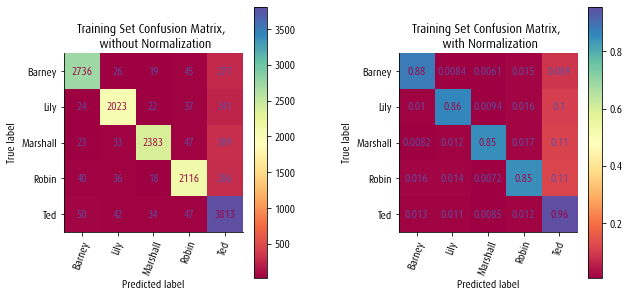

Cohen's Kappa Score for Training Set:
0.857
Matthew's Correlation Coefficient for Training Set:
0.86
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.32      0.26      0.29      1529
        Lily       0.27      0.24      0.25      1156
    Marshall       0.29      0.22      0.25      1377
       Robin       0.25      0.19      0.22      1229
         Ted       0.32      0.49      0.39      1963

    accuracy                           0.30      7254
   macro avg       0.29      0.28      0.28      7254
weighted avg       0.29      0.30      0.29      7254



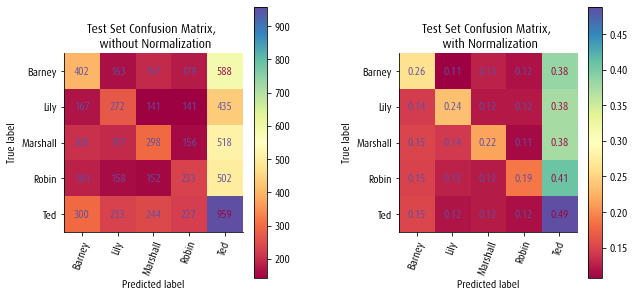

Cohen's Kappa Score for Test Set:
0.1
Matthew's Correlation Coefficient for Test Set:
0.102


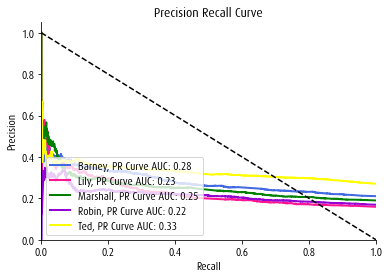

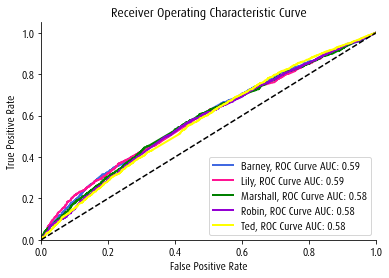

In [39]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T16RFpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier(n_estimators = 50)), 
]) #Creating Logistic Regression pipeline with count vectorizer

T16RFpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(T16RFpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR CV Model

confmat_and_classrep(T16RFpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test 1st tuned model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T16RFpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each character

tunedscores.loc['16'] = pd.Series({'Model Name': 'T16RFCV', 'Accuracy Score': 0.30, 'Precision Score': 0.29, 
                                    'Recall Score': 0.28, 'F1 Score': 0.28, "Cohen's Kappa Score": 0.098, 
                                    "Matthew's Correlation Coefficient": 0.099, 'Barn PRC': 0.29, 'Lily PRC': 0.23, 
                                   'Mar PRC': 0.25, 'Rob PRC': 0.22, 'Ted PRC': 0.33, 'Barn ROC': 0.59, 
                                   'Lily ROC': 0.59, 'Mar ROC': 0.58, 'Rob ROC': 0.58, 'Ted ROC': 0.58}) #Inputting

### Tuned Model 17: Class Weight = Balanced, Number of Estimators = 10

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.93      0.87      0.90      3103
        Lily       0.88      0.87      0.87      2347
    Marshall       0.94      0.84      0.89      2795
       Robin       0.69      0.92      0.79      2496
         Ted       0.92      0.84      0.88      3986

    accuracy                           0.87     14727
   macro avg       0.87      0.87      0.87     14727
weighted avg       0.88      0.87      0.87     14727



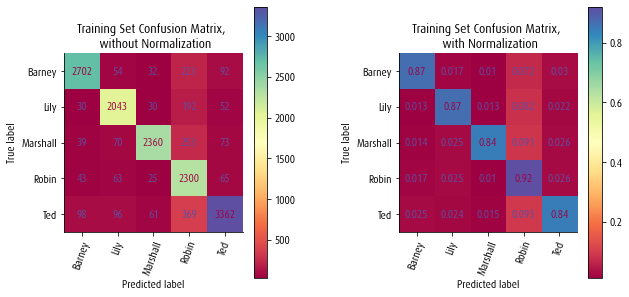

Cohen's Kappa Score for Training Set:
0.833
Matthew's Correlation Coefficient for Training Set:
0.835
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.29      0.26      0.28      1529
        Lily       0.25      0.26      0.26      1156
    Marshall       0.26      0.22      0.24      1377
       Robin       0.21      0.31      0.25      1229
         Ted       0.33      0.29      0.31      1963

    accuracy                           0.27      7254
   macro avg       0.27      0.27      0.27      7254
weighted avg       0.28      0.27      0.27      7254



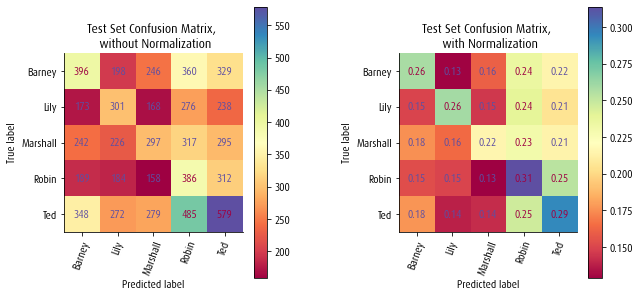

Cohen's Kappa Score for Test Set:
0.084
Matthew's Correlation Coefficient for Test Set:
0.084


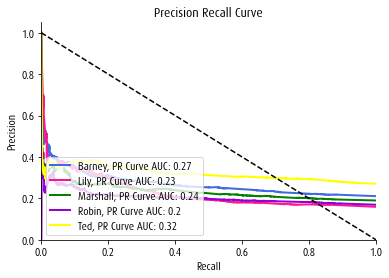

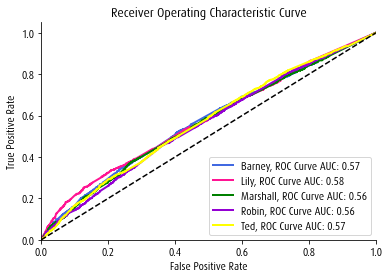

In [40]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T17RFpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier(n_estimators = 10, class_weight = 'balanced')), 
]) #Creating Logistic Regression pipeline with count vectorizer

T17RFpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(T17RFpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR CV Model

confmat_and_classrep(T17RFpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test 1st tuned model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T17RFpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each character

tunedscores.loc['17'] = pd.Series({'Model Name': 'T17RFCV', 'Accuracy Score': 0.27, 'Precision Score': 0.27, 
                                    'Recall Score': 0.27, 'F1 Score': 0.27, "Cohen's Kappa Score": 0.087, 
                                    "Matthew's Correlation Coefficient": 0.087, 'Barn PRC': 0.27, 'Lily PRC': 0.21, 
                                   'Mar PRC': 0.25, 'Rob PRC': 0.21, 'Ted PRC': 0.33, 'Barn ROC': 0.57, 
                                   'Lily ROC': 0.57, 'Mar ROC': 0.58, 'Rob ROC': 0.57, 'Ted ROC': 0.57}) #Inputting

### Tuned Model 18: Class Weight = Balanced; Number of Estimators = 50

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.94      0.89      0.91      3103
        Lily       0.88      0.88      0.88      2347
    Marshall       0.95      0.86      0.90      2795
       Robin       0.72      0.92      0.81      2496
         Ted       0.93      0.86      0.89      3986

    accuracy                           0.88     14727
   macro avg       0.88      0.88      0.88     14727
weighted avg       0.89      0.88      0.88     14727



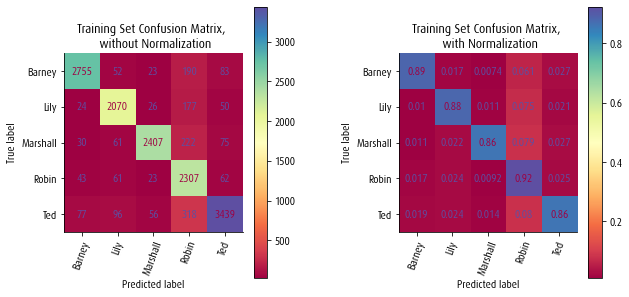

Cohen's Kappa Score for Training Set:
0.851
Matthew's Correlation Coefficient for Training Set:
0.852
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.31      0.26      0.28      1529
        Lily       0.25      0.26      0.25      1156
    Marshall       0.26      0.22      0.24      1377
       Robin       0.21      0.29      0.25      1229
         Ted       0.33      0.33      0.33      1963

    accuracy                           0.28      7254
   macro avg       0.27      0.27      0.27      7254
weighted avg       0.28      0.28      0.28      7254



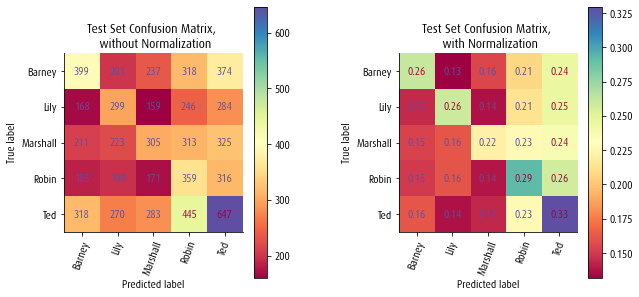

Cohen's Kappa Score for Test Set:
0.09
Matthew's Correlation Coefficient for Test Set:
0.09


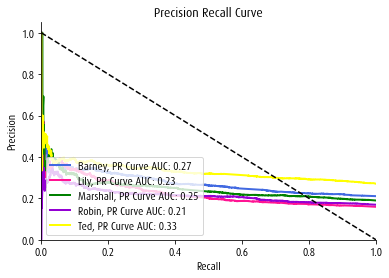

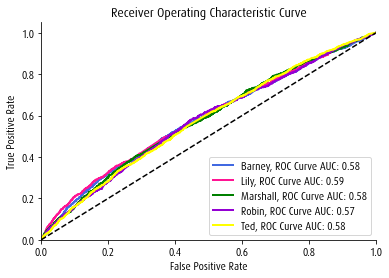

In [41]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T18RFpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier(n_estimators = 50, class_weight = 'balanced')), 
]) #Creating Logistic Regression pipeline with count vectorizer

T18RFpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(T18RFpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR CV Model

confmat_and_classrep(T18RFpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test 1st tuned model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T18RFpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each character

tunedscores.loc['18'] = pd.Series({'Model Name': 'T18RFCV', 'Accuracy Score': 0.28, 'Precision Score': 0.28, 
                                    'Recall Score': 0.28, 'F1 Score': 0.27, "Cohen's Kappa Score": 0.094, 
                                    "Matthew's Correlation Coefficient": 0.095, 'Barn PRC': 0.28, 'Lily PRC': 0.22, 
                                   'Mar PRC': 0.25, 'Rob PRC': 0.22, 'Ted PRC': 0.33, 'Barn ROC': 0.59, 
                                   'Lily ROC': 0.58, 'Mar ROC': 0.58, 'Rob ROC': 0.58, 'Ted ROC': 0.58}) #Inputting

## Random Forest using TF-IDF Vectorizer

### Tuning Model 19: Class Weight = Balanced

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.94      0.89      0.91      3103
        Lily       0.90      0.88      0.89      2347
    Marshall       0.93      0.86      0.90      2795
       Robin       0.71      0.93      0.80      2496
         Ted       0.94      0.85      0.89      3986

    accuracy                           0.88     14727
   macro avg       0.88      0.88      0.88     14727
weighted avg       0.89      0.88      0.88     14727



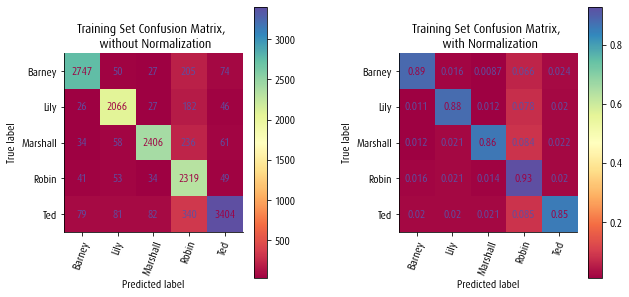

Cohen's Kappa Score for Training Set:
0.848
Matthew's Correlation Coefficient for Training Set:
0.85
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.32      0.29      0.31      1529
        Lily       0.26      0.19      0.22      1156
    Marshall       0.30      0.22      0.25      1377
       Robin       0.23      0.27      0.25      1229
         Ted       0.32      0.42      0.37      1963

    accuracy                           0.29      7254
   macro avg       0.29      0.28      0.28      7254
weighted avg       0.29      0.29      0.29      7254



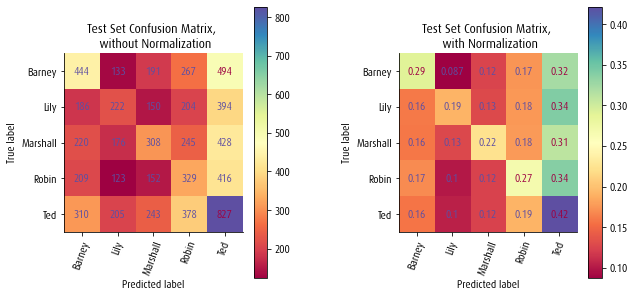

Cohen's Kappa Score for Test Set:
0.101
Matthew's Correlation Coefficient for Test Set:
0.101


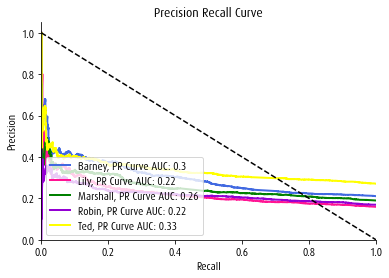

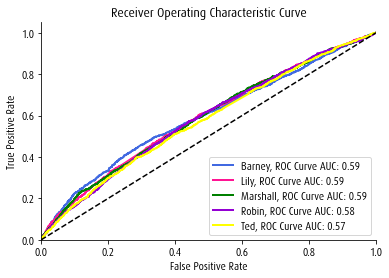

In [42]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T19RFpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier(class_weight = 'balanced')), 
]) #Creating Logistic Regression pipeline with count vectorizer

T19RFpipelineTF.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(T19RFpipelineTF, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR CV Model

confmat_and_classrep(T19RFpipelineTF, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test 1st tuned model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T19RFpipelineTF.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each character

tunedscores.loc['19'] = pd.Series({'Model Name': 'T19RFTF', 'Accuracy Score': 0.30, 'Precision Score': 0.29, 
                                    'Recall Score': 0.28, 'F1 Score': 0.29, "Cohen's Kappa Score": 0.107, 
                                    "Matthew's Correlation Coefficient": 0.108, 'Barn PRC': 0.29, 'Lily PRC': 0.23, 
                                   'Mar PRC': 0.26, 'Rob PRC': 0.22, 'Ted PRC': 0.34, 'Barn ROC': 0.60, 
                                   'Lily ROC': 0.60, 'Mar ROC': 0.59, 'Rob ROC': 0.58, 'Ted ROC': 0.58}) #Inputting

### Tuned Model 20: Number of Estimators = 10

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.93      0.88      0.90      3103
        Lily       0.91      0.85      0.88      2347
    Marshall       0.93      0.84      0.88      2795
       Robin       0.92      0.83      0.87      2496
         Ted       0.78      0.94      0.85      3986

    accuracy                           0.87     14727
   macro avg       0.89      0.87      0.88     14727
weighted avg       0.88      0.87      0.88     14727



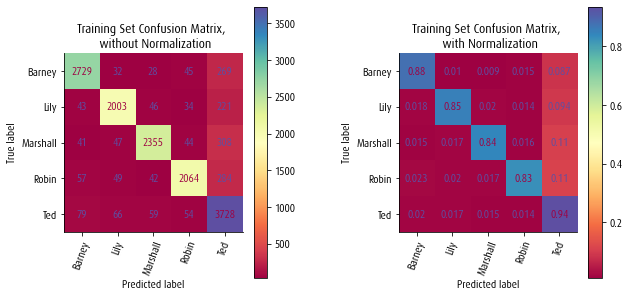

Cohen's Kappa Score for Training Set:
0.841
Matthew's Correlation Coefficient for Training Set:
0.843
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.28      0.29      0.28      1529
        Lily       0.23      0.19      0.21      1156
    Marshall       0.27      0.22      0.24      1377
       Robin       0.23      0.17      0.19      1229
         Ted       0.31      0.44      0.36      1963

    accuracy                           0.28      7254
   macro avg       0.27      0.26      0.26      7254
weighted avg       0.27      0.28      0.27      7254



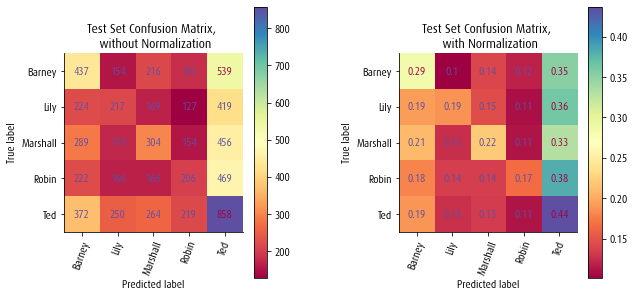

Cohen's Kappa Score for Test Set:
0.077
Matthew's Correlation Coefficient for Test Set:
0.078


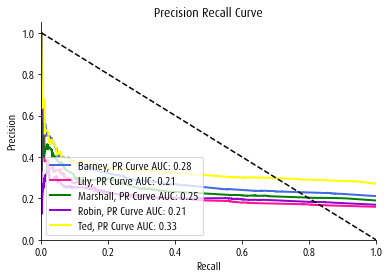

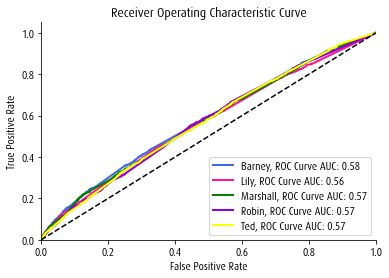

In [43]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T20RFpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier(n_estimators = 10)), 
]) #Creating Logistic Regression pipeline with count vectorizer

T20RFpipelineTF.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(T20RFpipelineTF, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR CV Model

confmat_and_classrep(T20RFpipelineTF, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test 1st tuned model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T20RFpipelineTF.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each character

tunedscores.loc['20'] = pd.Series({'Model Name': 'T20RFTF', 'Accuracy Score': 0.28, 'Precision Score': 0.27, 
                                    'Recall Score': 0.26, 'F1 Score': 0.26, "Cohen's Kappa Score": 0.078, 
                                    "Matthew's Correlation Coefficient": 0.079, 'Barn PRC': 0.28, 'Lily PRC': 0.22, 
                                   'Mar PRC': 0.24, 'Rob PRC': 0.20, 'Ted PRC': 0.32, 'Barn ROC': 0.58, 
                                   'Lily ROC': 0.58, 'Mar ROC': 0.56, 'Rob ROC': 0.55, 'Ted ROC': 0.56}) #Inputting

### Tuned Model 21: Number of Estimators = 50

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.95      0.88      0.91      3103
        Lily       0.93      0.86      0.89      2347
    Marshall       0.96      0.85      0.90      2795
       Robin       0.93      0.84      0.88      2496
         Ted       0.78      0.95      0.85      3986

    accuracy                           0.89     14727
   macro avg       0.91      0.88      0.89     14727
weighted avg       0.90      0.89      0.89     14727



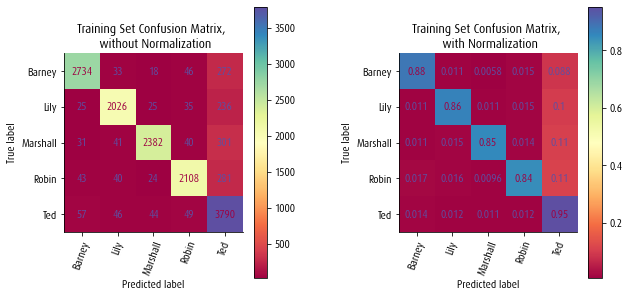

Cohen's Kappa Score for Training Set:
0.854
Matthew's Correlation Coefficient for Training Set:
0.857
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.32      0.29      0.30      1529
        Lily       0.26      0.18      0.22      1156
    Marshall       0.28      0.21      0.24      1377
       Robin       0.27      0.17      0.21      1229
         Ted       0.31      0.52      0.39      1963

    accuracy                           0.30      7254
   macro avg       0.29      0.27      0.27      7254
weighted avg       0.29      0.30      0.28      7254



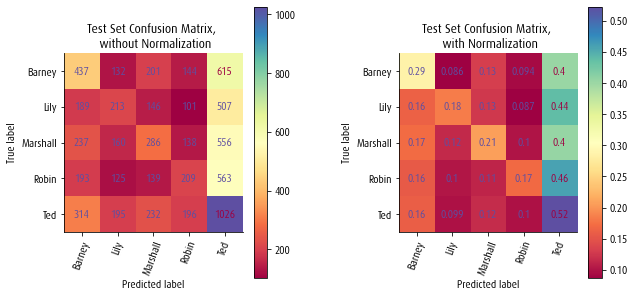

Cohen's Kappa Score for Test Set:
0.096
Matthew's Correlation Coefficient for Test Set:
0.099


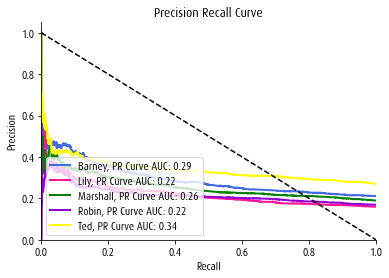

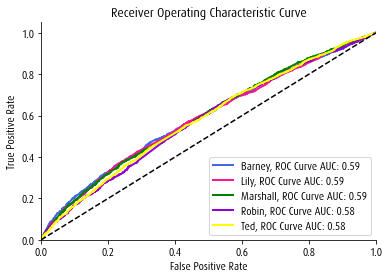

In [44]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T21RFpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier(n_estimators = 50)), 
]) #Creating Logistic Regression pipeline with count vectorizer

T21RFpipelineTF.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(T21RFpipelineTF, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR CV Model

confmat_and_classrep(T21RFpipelineTF, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test 1st tuned model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T21RFpipelineTF.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each character

tunedscores.loc['21'] = pd.Series({'Model Name': 'T21RFTF', 'Accuracy Score': 0.30, 'Precision Score': 0.29, 
                                    'Recall Score': 0.27, 'F1 Score': 0.27, "Cohen's Kappa Score": 0.097, 
                                    "Matthew's Correlation Coefficient": 0.100, 'Barn PRC': 0.29, 'Lily PRC': 0.23, 
                                   'Mar PRC': 0.25, 'Rob PRC': 0.21, 'Ted PRC': 0.34, 'Barn ROC': 0.59, 
                                   'Lily ROC': 0.59, 'Mar ROC': 0.58, 'Rob ROC': 0.57, 'Ted ROC': 0.58}) #Inputting

### Tuned Model 22: Class Weight = Balanced; Number of Estimators = 10

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.93      0.87      0.90      3103
        Lily       0.89      0.86      0.87      2347
    Marshall       0.92      0.85      0.88      2795
       Robin       0.71      0.91      0.79      2496
         Ted       0.92      0.85      0.88      3986

    accuracy                           0.87     14727
   macro avg       0.87      0.87      0.87     14727
weighted avg       0.88      0.87      0.87     14727



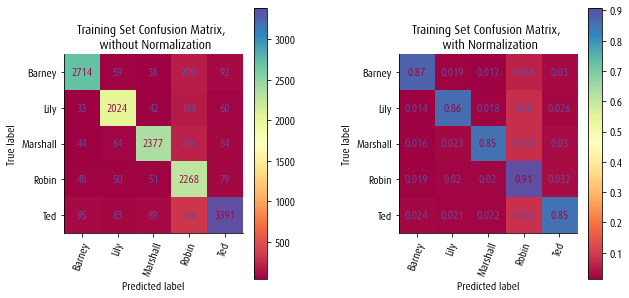

Cohen's Kappa Score for Training Set:
0.833
Matthew's Correlation Coefficient for Training Set:
0.835
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.31      0.31      0.31      1529
        Lily       0.23      0.20      0.22      1156
    Marshall       0.23      0.21      0.22      1377
       Robin       0.21      0.27      0.24      1229
         Ted       0.32      0.31      0.31      1963

    accuracy                           0.27      7254
   macro avg       0.26      0.26      0.26      7254
weighted avg       0.27      0.27      0.27      7254



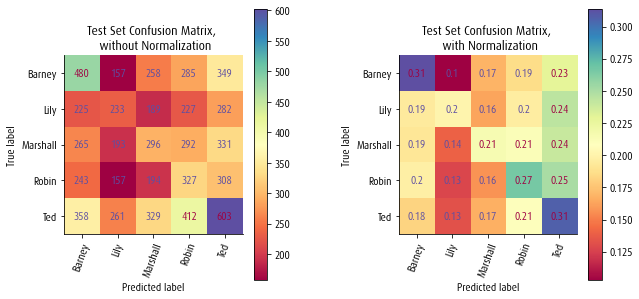

Cohen's Kappa Score for Test Set:
0.076
Matthew's Correlation Coefficient for Test Set:
0.077


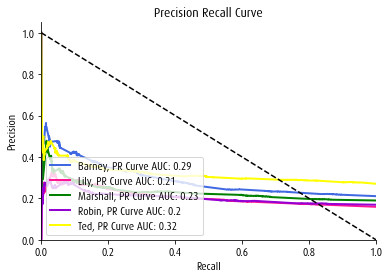

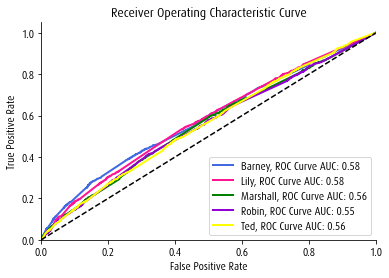

In [45]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T22RFpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier(n_estimators = 10, class_weight = 'balanced')), 
]) #Creating Logistic Regression pipeline with count vectorizer

T22RFpipelineTF.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(T22RFpipelineTF, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR CV Model

confmat_and_classrep(T22RFpipelineTF, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test 1st tuned model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T22RFpipelineTF.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each character

tunedscores.loc['22'] = pd.Series({'Model Name': 'T22RFTF', 'Accuracy Score': 0.27, 'Precision Score': 0.27, 
                                    'Recall Score': 0.27, 'F1 Score': 0.27, "Cohen's Kappa Score": 0.082, 
                                    "Matthew's Correlation Coefficient": 0.082, 'Barn PRC': 0.28, 'Lily PRC': 0.22, 
                                   'Mar PRC': 0.23, 'Rob PRC': 0.21, 'Ted PRC': 0.32, 'Barn ROC': 0.59, 
                                   'Lily ROC': 0.58, 'Mar ROC': 0.56, 'Rob ROC': 0.56, 'Ted ROC': 0.56}) #Inputting

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.94      0.88      0.91      3103
        Lily       0.88      0.88      0.88      2347
    Marshall       0.95      0.86      0.90      2795
       Robin       0.71      0.93      0.81      2496
         Ted       0.93      0.86      0.89      3986

    accuracy                           0.88     14727
   macro avg       0.88      0.88      0.88     14727
weighted avg       0.89      0.88      0.88     14727



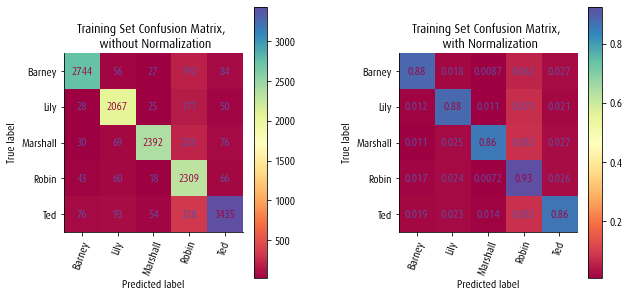

Cohen's Kappa Score for Training Set:
0.848
Matthew's Correlation Coefficient for Training Set:
0.85
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.32      0.29      0.31      1529
        Lily       0.26      0.20      0.23      1156
    Marshall       0.30      0.23      0.26      1377
       Robin       0.24      0.28      0.26      1229
         Ted       0.33      0.41      0.36      1963

    accuracy                           0.30      7254
   macro avg       0.29      0.29      0.29      7254
weighted avg       0.30      0.30      0.29      7254



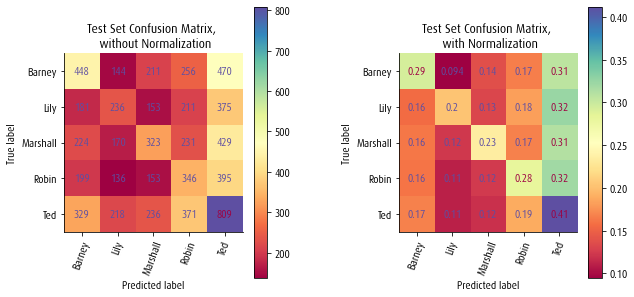

Cohen's Kappa Score for Test Set:
0.107
Matthew's Correlation Coefficient for Test Set:
0.108


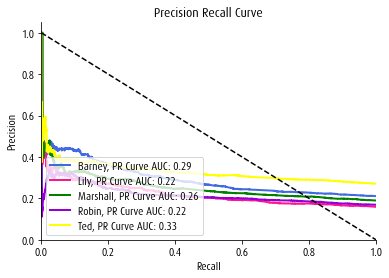

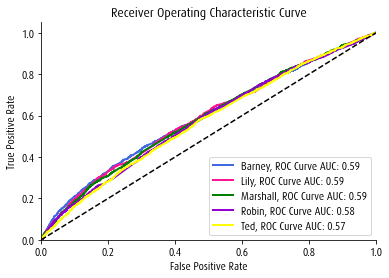

In [46]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T23RFpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier(n_estimators = 50, class_weight = 'balanced')), 
]) #Creating Logistic Regression pipeline with count vectorizer

T23RFpipelineTF.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(T23RFpipelineTF, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR CV Model

confmat_and_classrep(T23RFpipelineTF, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test 1st tuned model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T23RFpipelineTF.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each character

tunedscores.loc['23'] = pd.Series({'Model Name': 'T23RFTF', 'Accuracy Score': 0.29, 'Precision Score': 0.29, 
                                    'Recall Score': 0.28, 'F1 Score': 0.28, "Cohen's Kappa Score": 0.099, 
                                    "Matthew's Correlation Coefficient": 0.100, 'Barn PRC': 0.29, 'Lily PRC': 0.22, 
                                   'Mar PRC': 0.25, 'Rob PRC': 0.22, 'Ted PRC': 0.33, 'Barn ROC': 0.59, 
                                   'Lily ROC': 0.58, 'Mar ROC': 0.58, 'Rob ROC': 0.58, 'Ted ROC': 0.57}) #Inputting

# Comparing Tuned Models

Let's compare our tuned model scores on our Cohen's Kappa metric.

In [47]:
tunedscores.sort_values(by = ["Cohen's Kappa Score"], ascending = False) #Comparing tuned models

Model Name Accuracy Score Precision Score Recall Score F1 Score  \
2      T2LRCV           0.32            0.32         0.29     0.29   
4      T4LRCV            0.3             0.3          0.3     0.29   
12   T12MNBCV           0.31            0.31         0.29     0.29   
13   T13MNBCV           0.32            0.31         0.29     0.29   
11   T11MNBCV           0.31            0.31         0.29     0.29   
1      T1LRCV           0.29             0.3         0.29     0.29   
6      T6LRTF            0.3            0.29         0.29     0.29   
9      T9LRTF            0.3            0.29         0.29     0.29   
3      T3LRCV            0.3            0.29         0.28     0.28   
19    T19RFTF            0.3            0.29         0.28     0.29   
7      T7LRTF           0.32            0.32         0.28     0.26   
8      T8LRTF            0.3            0.29         0.28     0.28   
5      T5LRCV           0.28            0.28         0.28     0.28   
14    T14RFCV           0.29            0.28         0.28     0.28   
23    T23RFTF           0.29            0.29         0.28     0.28   
16    T16RFCV            0.3            0.29         0.28     0.28   
21    T21RFTF            0.3            0.29         0.27     0.27   
10    T10LRTF           0.29            0.28         0.28     0.28   
18    T18RFCV           0.28            0.28         0.28     0.27   
17    T17RFCV           0.27            0.27         0.27     0.27   
22    T22RFTF           0.27            0.27         0.27     0.27   
15    T15RFCV           0.28            0.27         0.26     0.26   
20    T20RFTF           0.28            0.27         0.26     0.26   

   Cohen's Kappa Score Matthew's Correlation Coefficient Barn PRC Lily PRC  \
2                0.125                              0.13     0.34     0.26   
4                0.121                             0.122     0.34     0.26   
12               0.119                             0.122      0.3     0.24   
13               0.119                             0.122     0.32     0.25   
11               0.117                              0.12      0.3     0.24   
1                0.116                             0.117     0.33     0.25   
6                0.115                             0.115     0.32     0.25   
9                0.111                             0.111     0.32     0.26   
3                0.108                             0.109     0.29     0.23   
19               0.107                             0.108     0.29     0.23   
7                0.105                             0.115     0.32     0.26   
8                0.105                             0.105      0.3     0.23   
5                0.101                             0.102     0.28     0.23   
14                 0.1                             0.101     0.28     0.23   
23               0.099                               0.1     0.29     0.22   
16               0.098                             0.099     0.29     0.23   
21               0.097                               0.1     0.29     0.23   
10               0.096                             0.096     0.29     0.22   
18               0.094                             0.095     0.28     0.22   
17               0.087                             0.087     0.27     0.21   
22               0.082                             0.082     0.28     0.22   
15                0.08                             0.081     0.27     0.21   
20               0.078                             0.079     0.28     0.22   

   Mar PRC Rob PRC Ted PRC Barn ROC Lily ROC Mar ROC Rob ROC Ted ROC  
2     0.28    0.24    0.36     0.62     0.62     0.6     0.6    0.61  
4     0.27    0.24    0.36     0.62     0.62     0.6     0.6    0.61  
12    0.27    0.24    0.35     0.59      0.6    0.59     0.6    0.59  
13    0.27    0.25    0.35      0.6     0.61    0.59     0.6     0.6  
11    0.27    0.23    0.35     0.59      0.6    0.59    0.59    0.59  
1     0.27    0.24    0

So we have our top performing models, but the numbers don't vary too far from our original baseline models. The best model *Logistic Regression using Count Vectorizer with C = 0.5* yielded a Cohen's Kappa score of .125 and an accuracy of 0.32; so it only did slightly better than the original model's Cohen's Kappa score of 0.121, but the accuracy remained the same. Virtually all the tuned models did just slightly better, which is an improvement considering how imbalanced the data was AND how similar each of the character's vocabulary was.

Let's try out some more tuning on our top performing model, and see if we're able to get some better results.

# Hyperparameter Tuning with our Top Model

In the following cells I try a few more different parameters and see if and how that changes our results.

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.48      0.42      0.45      3103
        Lily       0.60      0.18      0.28      2347
    Marshall       0.51      0.29      0.37      2795
       Robin       0.53      0.19      0.28      2496
         Ted       0.37      0.81      0.50      3986

    accuracy                           0.42     14727
   macro avg       0.50      0.38      0.38     14727
weighted avg       0.48      0.42      0.39     14727



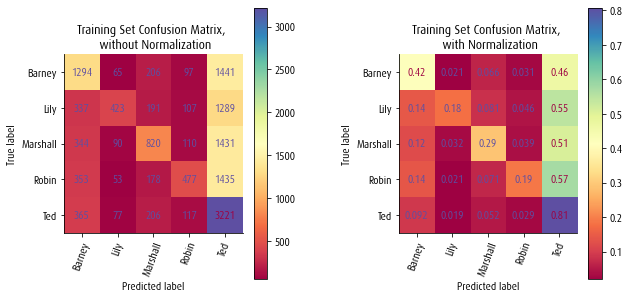

Cohen's Kappa Score for Training Set:
0.242
Matthew's Correlation Coefficient for Training Set:
0.269
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.33      0.29      0.31      1529
        Lily       0.42      0.11      0.18      1156
    Marshall       0.30      0.17      0.22      1377
       Robin       0.27      0.09      0.13      1229
         Ted       0.31      0.70      0.43      1963

    accuracy                           0.32      7254
   macro avg       0.33      0.27      0.25      7254
weighted avg       0.32      0.32      0.27      7254



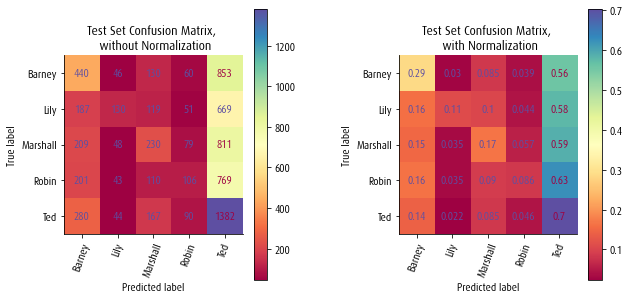

Cohen's Kappa Score for Test Set:
0.098
Matthew's Correlation Coefficient for Test Set:
0.111


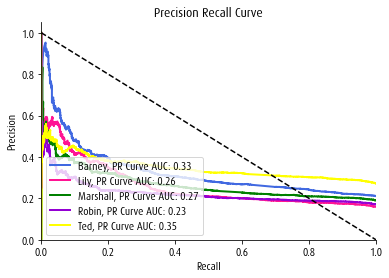

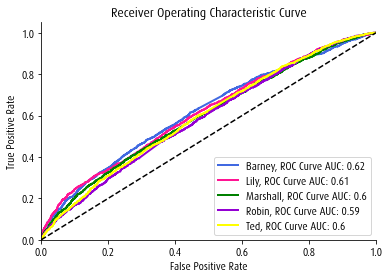

In [48]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

HT1 = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 100, penalty = 'l1', solver = 'saga')), 
]) #Creating Logistic Regression pipeline with count vectorizer

HT1.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(HT1, X_train, y_train_enc, le.classes_, 'Training') #Evaluating train 1st tuned model

confmat_and_classrep(HT1, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test 1st tuned model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = HT1.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each character

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.47      0.41      0.44      3103
        Lily       0.59      0.17      0.27      2347
    Marshall       0.50      0.28      0.36      2795
       Robin       0.52      0.18      0.27      2496
         Ted       0.36      0.81      0.50      3986

    accuracy                           0.42     14727
   macro avg       0.49      0.37      0.37     14727
weighted avg       0.47      0.42      0.38     14727



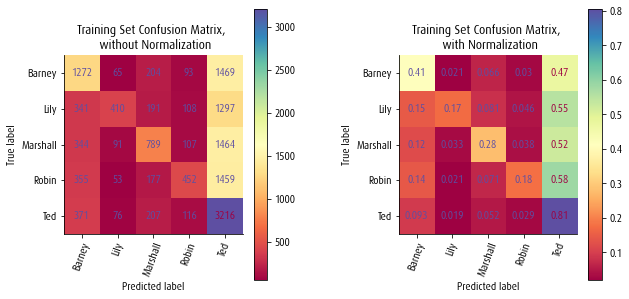

Cohen's Kappa Score for Training Set:
0.233
Matthew's Correlation Coefficient for Training Set:
0.26
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.34      0.29      0.31      1529
        Lily       0.41      0.11      0.17      1156
    Marshall       0.30      0.16      0.21      1377
       Robin       0.28      0.09      0.13      1229
         Ted       0.31      0.71      0.43      1963

    accuracy                           0.32      7254
   macro avg       0.33      0.27      0.25      7254
weighted avg       0.32      0.32      0.27      7254



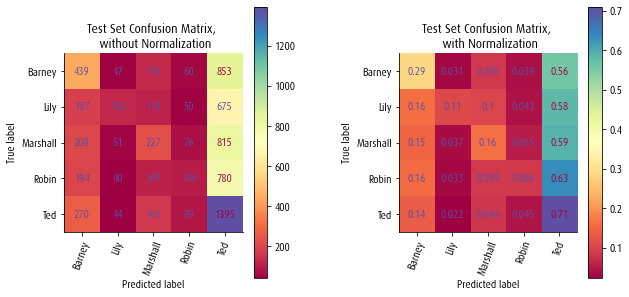

Cohen's Kappa Score for Test Set:
0.098
Matthew's Correlation Coefficient for Test Set:
0.111


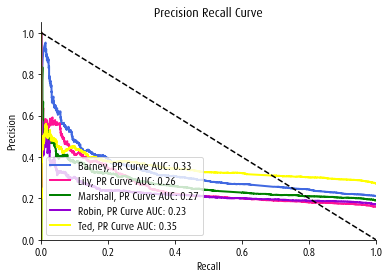

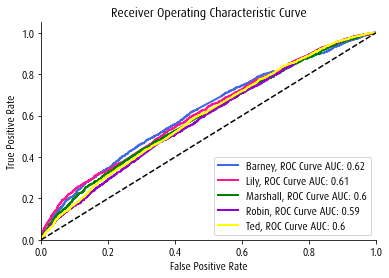

In [49]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

HT2 = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 10, penalty = 'l1', solver = 'saga')), 
]) #Creating Logistic Regression pipeline with count vectorizer

HT2.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(HT2, X_train, y_train_enc, le.classes_, 'Training') #Evaluating train 1st tuned model

confmat_and_classrep(HT2, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test 1st tuned model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = HT2.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each character

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.43      0.35      0.38      3103
        Lily       0.52      0.13      0.20      2347
    Marshall       0.45      0.21      0.29      2795
       Robin       0.46      0.12      0.18      2496
         Ted       0.33      0.81      0.47      3986

    accuracy                           0.37     14727
   macro avg       0.44      0.32      0.31     14727
weighted avg       0.43      0.37      0.33     14727



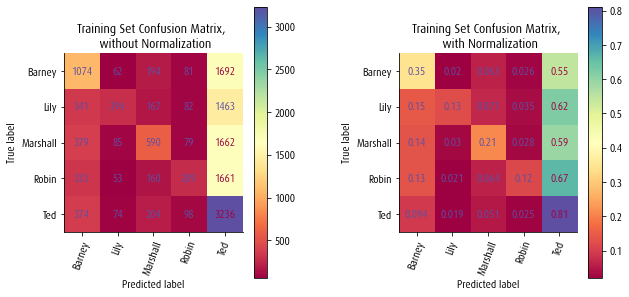

Cohen's Kappa Score for Training Set:
0.169
Matthew's Correlation Coefficient for Training Set:
0.198
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.34      0.27      0.30      1529
        Lily       0.42      0.09      0.15      1156
    Marshall       0.31      0.15      0.20      1377
       Robin       0.28      0.07      0.11      1229
         Ted       0.30      0.75      0.43      1963

    accuracy                           0.31      7254
   macro avg       0.33      0.27      0.24      7254
weighted avg       0.33      0.31      0.26      7254



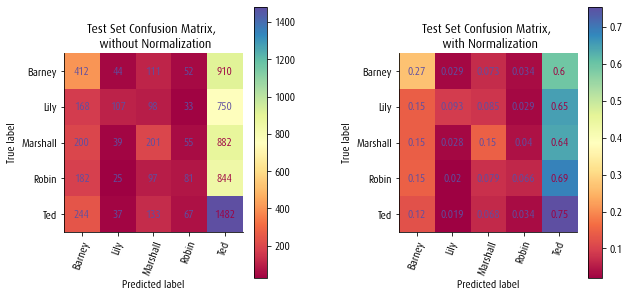

Cohen's Kappa Score for Test Set:
0.092
Matthew's Correlation Coefficient for Test Set:
0.109


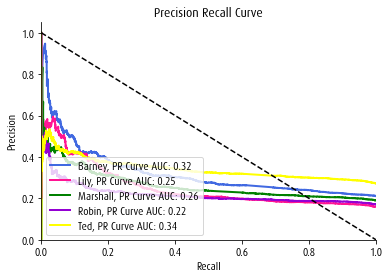

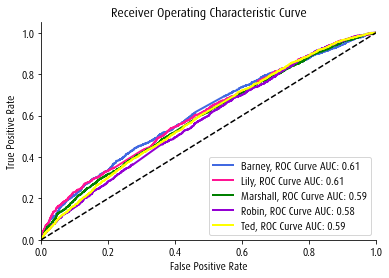

In [50]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

HT3 = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 1, penalty = 'l1', solver = 'saga')), 
]) #Creating Logistic Regression pipeline with count vectorizer

HT3.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(HT3, X_train, y_train_enc, le.classes_, 'Training') #Evaluating train 1st tuned model

confmat_and_classrep(HT3, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test 1st tuned model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = HT3.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each character

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.53      0.48      0.50      3103
        Lily       0.64      0.27      0.38      2347
    Marshall       0.55      0.35      0.43      2795
       Robin       0.56      0.27      0.36      2496
         Ted       0.40      0.80      0.53      3986

    accuracy                           0.47     14727
   macro avg       0.54      0.43      0.44     14727
weighted avg       0.52      0.47      0.45     14727



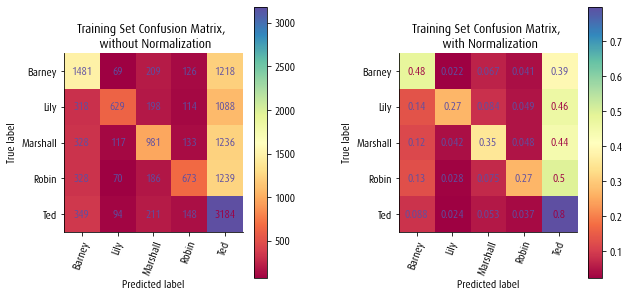

Cohen's Kappa Score for Training Set:
0.311
Matthew's Correlation Coefficient for Training Set:
0.333
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.35      0.30      0.32      1529
        Lily       0.39      0.14      0.21      1156
    Marshall       0.31      0.19      0.24      1377
       Robin       0.28      0.12      0.17      1229
         Ted       0.32      0.66      0.43      1963

    accuracy                           0.32      7254
   macro avg       0.33      0.28      0.27      7254
weighted avg       0.33      0.32      0.29      7254



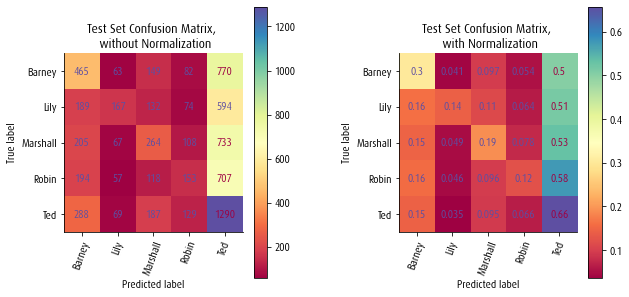

Cohen's Kappa Score for Test Set:
0.113
Matthew's Correlation Coefficient for Test Set:
0.123


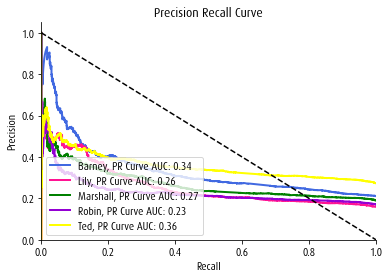

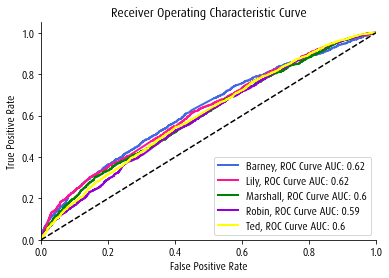

In [51]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

HT4 = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 100, penalty = 'none', solver = 'sag')), 
]) #Creating Logistic Regression pipeline with count vectorizer

HT4.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(HT4, X_train, y_train_enc, le.classes_, 'Training') #Evaluating train 1st tuned model

confmat_and_classrep(HT4, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test 1st tuned model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = HT4.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each character

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.53      0.48      0.50      3103
        Lily       0.64      0.27      0.38      2347
    Marshall       0.55      0.35      0.43      2795
       Robin       0.56      0.27      0.36      2496
         Ted       0.40      0.80      0.53      3986

    accuracy                           0.47     14727
   macro avg       0.54      0.43      0.44     14727
weighted avg       0.52      0.47      0.45     14727



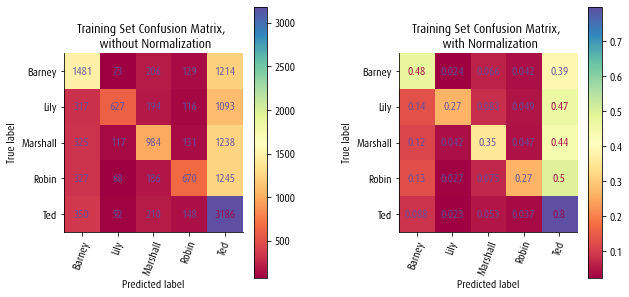

Cohen's Kappa Score for Training Set:
0.311
Matthew's Correlation Coefficient for Training Set:
0.333
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.35      0.30      0.32      1529
        Lily       0.40      0.15      0.21      1156
    Marshall       0.31      0.19      0.24      1377
       Robin       0.28      0.13      0.17      1229
         Ted       0.31      0.66      0.42      1963

    accuracy                           0.32      7254
   macro avg       0.33      0.28      0.27      7254
weighted avg       0.33      0.32      0.29      7254



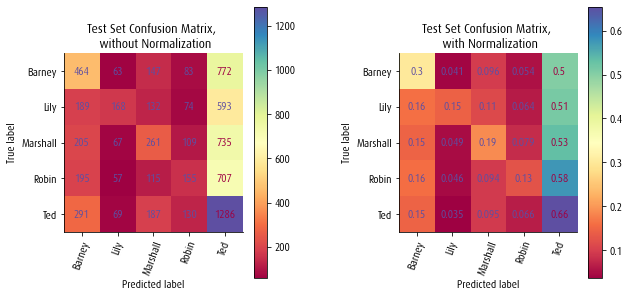

Cohen's Kappa Score for Test Set:
0.112
Matthew's Correlation Coefficient for Test Set:
0.122


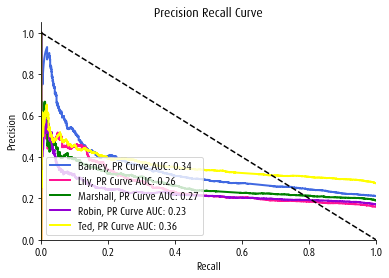

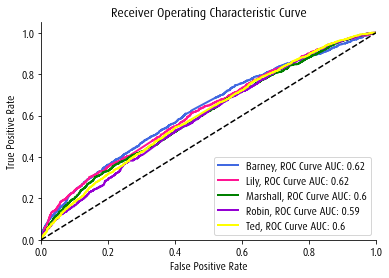

In [52]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

HT5 = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 0.01, penalty = 'none', solver = 'sag')), 
]) #Creating Logistic Regression pipeline with count vectorizer

HT5.fit(X_train, y_train_enc) #Fitting to pipeline

confmat_and_classrep(HT5, X_train, y_train_enc, le.classes_, 'Training') #Evaluating train 1st tuned model

confmat_and_classrep(HT5, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test 1st tuned model

lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = HT5.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each character

roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each character

Okay so after running a few more models and adding some more parameters to tune, the results are all staying about the same so we'll stick with the Logistic Regression using Count Vectorizer and C set to 0.5 as our final model. While that is by far not the best we could do, under the current circumstances and time constraints it is what we will use.

# Conclusions and Recommendations

Our final model is: **Logistic Regression using Count Vectorizer with C = 0.5**, this model yielded an accuracy of 32%, which is better than random guessing (20%) but still not that great. It also yielded the highest Cohen's Kappa score, 0.125, which is the metric we were using to determine the best model as it accounts for imbalanced data.

Looking at the results of our Precision Recall Curve scores, it does not appear that any of our classifiers are good. They all perform worse than random classifiers as their AUC scores all fall under 0.5 (the highest is 0.36 (Ted), lowest is 0.24 (Robin)). There are a lot of things that could explain why this is, a big one I think is because they all have very similar vocabularies, and more probably could have been done to parse through and denote differences prior to preparing the data to be modeled.

One thing I'd like to note is that I did not use stemming/lemmatization as part of text preprocessing. I chose to not utilize this aspect of NLP because in my experience with text data, I feel that it detracts too much from the meaning of statements. This is just my opinion, and if you choose to try this project feel free to use stemma/lemma if you feel it's right.

While the EDA was very successful, I would not consider this modeling process in the same boat. Despite numerous tuning attempts, the accuracy of our models remained the same virtually across the board. Again, denoting more differences and parsing through the data more thoroughly prior to modeling is something that could be done to help relieve the burden of this issue but at this point there is not time to do so.

Further iterations of this project could, and should, include reviewing the exploration process and finding more specific differences between character speech and how that can be applied prior to modeling. In addition, more exploration can be done. I chose to not continue to go down the graph-making rabbit hole but more graphs can be made exploring the common phrases used and by who, common words/phrases by season, deeper analysis into themes across seasons and characters, etc. Even more exploring beyond that can be done, but if I keep listing we'll be here all week. There was just so much to do with this data and not enough time in the day! The modeling process also did not need to be classifying by character, it also could have attempted to classify which lines belonged to which season, or it could have been more specific and only looked at character lines from season 1 rather than all seasons. Again, there are numerous further iterations of this project that I would love to explore just for the heck of it.

While our models were not the best, we did create a robust exploratory data analysis that I feel encompasses the heart of the show. You can see the rise and fall of character relationships as well as how some of our favorite lines and catchphrases are used; all of this adds to the ambience of the How I Met Your Mother experience, and as an avid fan I'm glad I got to re-experience the show through this avenue.